In [69]:
# from google.colab import drive
# drive.mount('/content/drive')

In [70]:
# # Uncomment and run to install packages
# # After installed, restart kernel
# !pip install nbformat
# !pip install plotly
# !pip install googletrans==3.1.0a0
# !pip install sentence_transformers
# !pip install torch
# !pip install lightgbm
# !pip install xgboost

In [71]:
mkdir clean

A subdirectory or file clean already exists.


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [73]:

def show_null_values(data):
    # Calculate the number of non-null and null values for each feature
    nonnull_counts = data.notnull().sum()
    null_counts = data.isnull().sum()

    # Create figure
    fig = go.Figure()

    # Add a column representing the number of non-null values for each feature
    fig.add_trace(go.Bar(
        x=data.columns,
        y=nonnull_counts,
        name='Not Null',
        marker_color='skyblue'
    ))

    # Add a column representing the number of non-null values for each fe
    fig.add_trace(go.Bar(
        x=data.columns,
        y=null_counts,
        name='Null',
        marker_color='red'
    ))

    # update layout
    fig.update_layout(
        title='Number of Null and Not Null Values for Each Feature',
        xaxis_title='Feature',
        yaxis_title='Count',
        barmode='stack',
        xaxis_tickangle=-45,
        height=400,
        width=1100
    )

    fig.show()

In [74]:
# Read train file, change directory to run
train_context = pd.read_csv('train_set/context.csv')
train_mobile_plan_attr = pd.read_csv('train_set/mobile_plan_attr.csv', sep=';')
train_mobile_plan_user = pd.read_csv('train_set/mobile_plan_user.csv')
train_user = pd.read_csv('train_set/user.csv')

# Read test file, change directory to run
test_context = pd.read_csv('test_set/context.csv')
test_mobile_plan_attr = pd.read_csv('test_set/mobile_plan_attr.csv', sep=';')
test_mobile_plan_user = pd.read_csv('test_set/mobile_plan_user.csv')
test_user = pd.read_csv('test_set/user.csv')

# User

In [75]:
# Change income into VND
EXCHANGE_RATE = 24000
def turn_into_VND(sample):
    if sample['income'][-1] == '$':
        return int(sample['income'][:-1]) * EXCHANGE_RATE
    else:
        return int(sample['income'][:-4])

In [76]:
train_user['income'] = train_user.apply(turn_into_VND, axis=1)
test_user['income'] = test_user.apply(turn_into_VND, axis=1)

In [77]:
# Normalize 'living_with'
train_user['living_with'] = train_user['living_with'].str.replace(' ', '')
test_user['living_with'] = test_user['living_with'].str.replace(' ', '')

In [78]:
# Create 'Marriage' and 'Num_child'
train_user['Marriage'] = train_user['living_with'].str[:-2]
train_user['Num_child'] = train_user['living_with'].str[-1].astype(int)

test_user['Marriage'] = test_user['living_with'].str[:-2]
test_user['Num_child'] = test_user['living_with'].str[-1].astype(int)

In [79]:
# Capitalize 'nation'
train_user['nation'] = train_user['nation'].str.capitalize()
test_user['nation'] = test_user['nation'].str.capitalize()

In [80]:
def get_age_q(df_user):
    age_q1 = df_user['age'].describe()['min'].astype(int)
    age_q2 = df_user['age'].describe()['25%'].astype(int)
    age_q3 = df_user['age'].describe()['50%'].astype(int)
    age_q4 = df_user['age'].describe()['75%'].astype(int)
    return age_q1, age_q2, age_q3, age_q4

In [81]:
def create_age_quartile(sample, age_q1, age_q2, age_q3, age_q4):
    age = sample['age']
    if age < age_q2:
        return f"{age_q1}-{age_q2}"
    elif age < age_q3:
        return f"{age_q2}-{age_q3}"
    elif age < age_q4:
        return f"{age_q3}-{age_q4}"
    else:
        return f"{age_q4}+"

In [82]:
# Create 'age_quartile'
age_q1, age_q2, age_q3, age_q4 = get_age_q(train_user)
train_user['age_quartile'] = train_user.apply(create_age_quartile, args=(age_q1, age_q2, age_q3, age_q4), axis=1)
test_user['age_quartile'] = test_user.apply(create_age_quartile, args=(age_q1, age_q2, age_q3, age_q4), axis=1)

In [83]:
train_user = train_user.sort_values(by = 'id')
test_user = test_user.sort_values(by = 'id')

In [84]:
from googletrans import Translator
translator = Translator()

In [85]:
# # translate 'job' into english
# train_user['job_en'] = train_user['job'].apply(translator.translate, dest='en').apply(getattr, args=('text',))
# test_user['job_en'] = test_user['job'].apply(translator.translate, dest='en').apply(getattr, args=('text',))

In [86]:
# from sentence_transformers import SentenceTransformer, util
# model = SentenceTransformer("all-mpnet-base-v2", device="cuda")

In [87]:
# query_embedding = model.encode(train_user['job_en'])
# passage_embedding = model.encode([
#     "Researcher/Specialist",
#     "Economist",
#     "Public service",
#     "Influencer/Singer/Actor",
#     "Software engineer",
#     "Healthcare",
#     "Bar",
#     "Legal service ",
#     "Mechanic",
#     "Banking/Finance/Tax",
#     "Graphic/Editor",
#     "Architecture Marketing/Advertising ",
#     "Housewife",
#     "Education",
#     "Science, Engineer, Technology, Mathematics ",
#     "Freelancer (writer...)",
#     "Farmer ",
#     "Office",
#     "Pilot/Aviation",
#     "Geological Research",
#     "Driving"
# ])

# # Extract embeddings and apply cosine similarity divide 'job_en' into 20 group (column career)
# similarities = util.cos_sim(query_embedding, passage_embedding)
# print("Similarity:", similarities)

In [88]:
# max_values = similarities.argmax(axis=1).numpy()
# train_user['index_career'] = max_values

In [89]:
# career_list = [
#     "Researcher/Specialist",
#     "Economist",
#     "Public service",
#     "Influencer/Singer/Actor",
#     "Software engineer",
#     "Healthcare",
#     "Bar",
#     "Legal service ",
#     "Mechanic",
#     "Banking/Finance/Tax",
#     "Graphic/Editor",
#     "Architecture Marketing/Advertising ",
#     "Housewife",
#     "Education",
#     "Science, Engineer, Technology, Mathematics ",
#     "Freelancer (writer...)",
#     "Farmer ",
#     "Office",
#     "Pilot/Aviation",
#     "Geological Research",
#     "Driving"
# ]

In [90]:
# train_user['career'] = train_user['index_career'].apply(lambda x: career_list[x])


In [91]:
# query_embedding = model.encode(test_user['job_en'])
# passage_embedding = model.encode([
#     "Researcher/Specialist",
#     "Economist",
#     "Public service",
#     "Influencer/Singer/Actor",
#     "Software engineer",
#     "Healthcare",
#     "Bar",
#     "Legal service ",
#     "Mechanic",
#     "Banking/Finance/Tax",
#     "Graphic/Editor",
#     "Architecture Marketing/Advertising ",
#     "Housewife",
#     "Education",
#     "Science, Engineer, Technology, Mathematics ",
#     "Freelancer (writer...)",
#     "Farmer ",
#     "Office",
#     "Pilot/Aviation",
#     "Geological Research",
#     "Driving"
# ])
# similarities = util.cos_sim(query_embedding, passage_embedding)
# print("Similarity:", similarities)

In [92]:
# max_values = similarities.argmax(axis=1).numpy()
# test_user['index_career'] = max_values

In [93]:
# test_user['career'] = test_user['index_career'].apply(lambda x: career_list[x])


In [94]:
train_user.to_csv('clean/train_user_cleaning.csv', index=False)
test_user.to_csv('clean/test_user_cleaning.csv', index=False)

In [95]:
train_user

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,Marriage,Num_child,age_quartile
3014,1000,董秀梅,Female,38,Masters,Education&Training&Library,844800000,Single_1,China,15520630534,数控操机,1,6,7,2,1,Single,1,31-41
3087,1001,Charles Lewis,Male,28,NaN,Computer & Mathematical,1456800000,Married_1,Us,+1-857-645-8187x641,Naval architect,0,3,1,1,3,Married,1,25-31
5311,1002,Фокина Анжела Александровна,Female,26,NaN,Office & Administrative Support,1958400000,Married_0,Russia,8 996 463 49 24,Океанолог,0,0,1,6,0,Married,0,25-31
453,1004,Cynthia Weiss,Female,46,NaN,Sales & Related,792000000,Married_1,England,001-657-987-2229x935,Administrator,1,0,3,1,0,Married,1,41+
8442,1005,Lisa Brown,Female,21,Associate,Food Preparation & Serving Related,505000000,Unmarried_3,England,9763598612,Lawyer,0,0,0,1,0,Unmarried,3,18-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6694,19994,Tony Wagner,Male,30,NaN,Healthcare Support,1120000000,Single_0,England,7194872478,Call centre manager,20,19,20,17,9,Single,0,25-31
499,19996,Jacqueline Ward,Female,27,Associate,Community & Social Services,1478400000,Unmarried_0,England,(772)252-7192,Associate Professor,0,2,1,2,1,Unmarried,0,25-31
2791,19997,Ria Atzler-Karge,Female,23,NaN,Student,1324800000,Single_0,Denmark,+49(0)7040 427636,Drogist,0,0,0,11,0,Single,0,18-25
9679,19998,Nathaniel Williams,Male,25,Bachelor,Unemployed,1298400000,Single_0,Us,3688501596,Bookseller,1,1,3,0,0,Single,0,25-31


In [96]:
test_user

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,Marriage,Num_child,age_quartile
908,1014,Lindsey Garcia,Female,40,Associate,Healthcare Practitioners & Technical,2004000000,Married_4,Australia,+61 2 6527 7772,"Scientist, biomedical",1,0,8,2,1,Married,4,31-41
545,1026,Madison Spears,Female,44,NaN,Arts Design Entertainment Sports & Media,2256000000,Married_0,Australia,(07)17500184,Counselling psychologist,2,3,6,7,2,Married,0,41+
826,1036,전혜진,Female,33,Masters,Computer & Mathematical,1776000000,Married_2,Korea,052-404-8756,종이제품 생산기 조작원,1,4,7,3,0,Married,2,31-41
970,1040,Rose Segebahn,Female,32,Bachelor,Computer & Mathematical,1770000000,Unmarried_1,Denmark,04865 24842,Augenoptiker,0,3,5,2,2,Unmarried,1,31-41
627,1060,Rafaela Melo,Female,46,NaN,Sales & Related,1035000000,Single_2,Brazil,31 4350-9756,Co-piloto,0,0,2,1,1,Single,2,41+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,19961,Lavínia Cunha,Female,37,NaN,Computer & Mathematical,615000000,Unmarried_1,Brazil,31 0516-0172,Empacotador,0,2,0,2,6,Unmarried,1,31-41
1091,19968,Samantha Beasley,Female,53,Highschool,Retired,453600000,Widowed_2,Australia,03-7403-9036,"Engineer, electrical",0,0,4,2,13,Widowed,2,41+
25,19981,이옥자,Female,72,NaN,Healthcare Support,830400000,Married_0,Korea,019-098-5467,마술사 및 기타 문화/ 예술 관련 종사자,3,1,5,8,3,Married,0,41+
629,19993,이서현,Female,49,NaN,Sales & Related,1102500000,Single_1,Korea,052-493-7736,사진기자 및 사진가,0,1,2,2,1,Single,1,41+


# Context

In [97]:
# Sort by id
train_context = train_context.sort_values(by = 'id')
test_context = test_context.sort_values(by = 'id')

In [98]:
def remove_unnecessary_symbol(sample):
    chars_to_remove = r"[()~\"%?&!]"
    sample = sample.str.replace(chars_to_remove, '', regex = True)
    sample = sample.str.replace(' ', '')
    return sample

In [99]:
# Normalize 'go_with' and 'weather' columns
train_context['go_with'] = remove_unnecessary_symbol(train_context['go_with'])
test_context['go_with'] = remove_unnecessary_symbol(test_context['go_with'])
train_context['weather'] = remove_unnecessary_symbol(train_context['weather'])
test_context['weather'] = remove_unnecessary_symbol(test_context['weather'])

In [100]:
# Normalize 'time' column
train_context['time'] = train_context['time'].str.replace(' ', '')
test_context['time'] = test_context['time'].str.replace(' ', '')

In [101]:
def get_time(sample):
    if sample['time'][-2:] == 'AM':
        return sample['time'][:-2] + ':00'
    elif sample['time'][-2:] == 'PM':
        return str(int(sample['time'][:-2]) + 12) + ':00'
    else:
        return sample['time']

In [102]:
# Normalize 'time' column

train_context['time'] = train_context.apply(get_time, axis=1)
test_context['time'] = test_context.apply(get_time, axis=1)

In [103]:
train_context.to_csv('clean/train_context_cleaning.csv', index=False)
test_context.to_csv('clean/test_context_cleaning.csv', index=False)

# Mobile plan user

In [104]:
train_mobile_plan_user

,id,mobile_plan,accept
0,11156.0,DATASILVER,1.0
1,4297.0,SOCIALMEDIAGOLD,1.0
2,13301.0,DATASILVER,1.0
3,9920.0,SOCIALMEDIAGOLD,1.0
4,8424.0,DATASILVER,1.0
...,...,...,...
45316,14977.0,DATASILVER,0.0
45317,5803.0,NaN,NaN
45318,2067.0,SOCIALMEDIAGOLD,NaN
45319,11678.0,DATACALL,0.0


In [105]:
test_mobile_plan_user

,id,coupon_id,accept
0,7067.0,DATASILVER,1.0
1,2114.0,SOCIALMEDIAGOLD,1.0
2,6582.0,DATASILVER,1.0
3,11379.0,DATASILVER,0.0
4,3986.0,DATACALL,1.0
...,...,...,...
1392,7602.0,NaN,NaN
1393,7602.0,DATAGOLD,0.0
1394,2838.0,DATASILVER,NaN
1395,8140.0,NaN,0.0


In [106]:
test_mobile_plan_user = test_mobile_plan_user.rename(columns={'coupon_id': 'mobile_plan'})

In [107]:
train_mobile_plan_user = train_mobile_plan_user.sort_values(by = 'id')
test_mobile_plan_user = test_mobile_plan_user.sort_values(by = 'id')

In [108]:
train_mobile_plan_user = train_mobile_plan_user.dropna()
test_mobile_plan_user = test_mobile_plan_user.dropna()

In [109]:
# Create a new mobile plan dataframe
train_mobile_plan_user_new = pd.DataFrame()
test_mobile_plan_user_new = pd.DataFrame()

train_mobile_plan_user_new['id'] = train_mobile_plan_user['id'].unique()
test_mobile_plan_user_new['id'] = test_mobile_plan_user['id'].unique()

In [110]:
# count number of suggestion
train_mobile_plan_user_new['number_of_suggestions'] = train_mobile_plan_user.groupby('id').size().values
test_mobile_plan_user_new['number_of_suggestions'] = test_mobile_plan_user.groupby('id').size().values

In [111]:
# count number of plans
train_mobile_plan_user_new['number_of_plans'] = train_mobile_plan_user.groupby('id')['mobile_plan'].nunique().values
test_mobile_plan_user_new['number_of_plans'] = test_mobile_plan_user.groupby('id')['mobile_plan'].nunique().values

In [112]:
# count number of accept
train_mobile_plan_user_new['number_of_accept'] = train_mobile_plan_user.groupby('id')['accept'].sum().values
test_mobile_plan_user_new['number_of_accept'] = test_mobile_plan_user.groupby('id')['accept'].sum().values

In [113]:
# count number of unique mobile_plan accepted
train_mobile_plan_user_new['number_of_accept_2'] = train_mobile_plan_user.drop_duplicates().groupby('id')['accept'].sum().values
test_mobile_plan_user_new['number_of_accept_2'] = test_mobile_plan_user.drop_duplicates().groupby('id')['accept'].sum().values

In [114]:
# show mobile_plan accepted
accepted_plans = train_mobile_plan_user[train_mobile_plan_user['accept'] == 1]
accepted_plans_grouped = accepted_plans.groupby('id')['mobile_plan'].apply(lambda x: ', '.join(sorted(x))).reset_index()
train_mobile_plan_user_new = pd.merge(train_mobile_plan_user_new, accepted_plans_grouped, on='id', how='left')

In [115]:
# show mobile_plan accepted

accepted_plans = test_mobile_plan_user[test_mobile_plan_user['accept'] == 1]
accepted_plans_grouped = accepted_plans.groupby('id')['mobile_plan'].apply(lambda x: ', '.join(sorted(x))).reset_index()
test_mobile_plan_user_new = pd.merge(test_mobile_plan_user_new, accepted_plans_grouped, on='id', how='left')

In [116]:
# if number_of_accept == 0, than the mobile_plan is Unknown
train_mobile_plan_user_new.loc[train_mobile_plan_user_new['number_of_accept'] == 0, 'mobile_plan'] = 'Unknown'
test_mobile_plan_user_new.loc[test_mobile_plan_user_new['number_of_accept'] == 0, 'mobile_plan'] = 'Unknown'

In [117]:
train_mobile_plan_user_new.to_csv("clean/train_mobile_plan_after_cleaning.csv")
test_mobile_plan_user_new.to_csv("clean/test_mobile_plan_after_cleaning.csv")

# Merge tables

In [118]:
# Merge tables
train_merge = pd.merge(train_user, train_context, on = 'id', how = 'left')
train_merge

,id,name,gender,age,education,profession,income,living_with,nation,phone,...,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
0,1000,董秀梅,Female,38,Masters,Education&Training&Library,844800000,Single_1,China,15520630534,...,Friends,Sunny,12:00,1,1,0,0,1,0,0
1,1001,Charles Lewis,Male,28,NaN,Computer & Mathematical,1456800000,Married_1,Us,+1-857-645-8187x641,...,Alone,Sunny,7:00,1,0,0,1,0,8,1
2,1002,Фокина Анжела Александровна,Female,26,NaN,Office & Administrative Support,1958400000,Married_0,Russia,8 996 463 49 24,...,Alone,Snowy,7:00,1,1,0,1,0,0,1
3,1004,Cynthia Weiss,Female,46,NaN,Sales & Related,792000000,Married_1,England,001-657-987-2229x935,...,Alone,Sunny,11:00,1,0,0,0,1,5,0
4,1005,Lisa Brown,Female,21,Associate,Food Preparation & Serving Related,505000000,Unmarried_3,England,9763598612,...,Alone,Sunny,17:00,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11567,19994,Tony Wagner,Male,30,NaN,Healthcare Support,1120000000,Single_0,England,7194872478,...,Alone,Sunny,7:00,1,1,0,0,1,0,0
11568,19996,Jacqueline Ward,Female,27,Associate,Community & Social Services,1478400000,Unmarried_0,England,(772)252-7192,...,Alone,Sunny,15:00,1,0,0,1,0,6,1
11569,19997,Ria Atzler-Karge,Female,23,NaN,Student,1324800000,Single_0,Denmark,+49(0)7040 427636,...,Alone,Sunny,15:00,1,0,0,1,0,11,1
11570,19998,Nathaniel Williams,Male,25,Bachelor,Unemployed,1298400000,Single_0,Us,3688501596,...,Friends,Snowy,19:00,1,1,0,0,1,0,0


In [119]:
train_merge = pd.merge(train_merge, train_mobile_plan_user_new, on = 'id', how = 'left')
train_merge

,id,name,gender,age,education,profession,income,living_with,nation,phone,...,viettel_no_2,to_hanoi,to_other,score,direction,number_of_suggestions,number_of_plans,number_of_accept,number_of_accept_2,mobile_plan
0,1000,董秀梅,Female,38,Masters,Education&Training&Library,844800000,Single_1,China,15520630534,...,0,0,1,0,0,4,3,1.0,1.0,DATASILVER
1,1001,Charles Lewis,Male,28,NaN,Computer & Mathematical,1456800000,Married_1,Us,+1-857-645-8187x641,...,0,1,0,8,1,3,2,1.0,1.0,SOCIALMEDIA
2,1002,Фокина Анжела Александровна,Female,26,NaN,Office & Administrative Support,1958400000,Married_0,Russia,8 996 463 49 24,...,0,1,0,0,1,1,1,1.0,1.0,SOCIALMEDIAGOLD
3,1004,Cynthia Weiss,Female,46,NaN,Sales & Related,792000000,Married_1,England,001-657-987-2229x935,...,0,0,1,5,0,1,1,0.0,0.0,Unknown
4,1005,Lisa Brown,Female,21,Associate,Food Preparation & Serving Related,505000000,Unmarried_3,England,9763598612,...,1,0,1,0,0,3,3,0.0,0.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11567,19994,Tony Wagner,Male,30,NaN,Healthcare Support,1120000000,Single_0,England,7194872478,...,0,0,1,0,0,1,1,0.0,0.0,Unknown
11568,19996,Jacqueline Ward,Female,27,Associate,Community & Social Services,1478400000,Unmarried_0,England,(772)252-7192,...,0,1,0,6,1,4,4,1.0,1.0,DATACALL
11569,19997,Ria Atzler-Karge,Female,23,NaN,Student,1324800000,Single_0,Denmark,+49(0)7040 427636,...,0,1,0,11,1,4,3,1.0,1.0,DATASILVER
11570,19998,Nathaniel Williams,Male,25,Bachelor,Unemployed,1298400000,Single_0,Us,3688501596,...,0,0,1,0,0,4,3,0.0,0.0,Unknown


In [120]:
# normalize viettel_no_2 and viettel_no_1
train_merge.loc[train_merge['viettel_no_2'] == 1, 'viettel_no_1'] = 0
train_merge.loc[train_merge['viettel_no_2'] == 1, 'viettel_no_0'] = 0
train_merge.loc[train_merge['viettel_no_1'] == 1, 'viettel_no_0'] = 0
train_merge

,id,name,gender,age,education,profession,income,living_with,nation,phone,...,viettel_no_2,to_hanoi,to_other,score,direction,number_of_suggestions,number_of_plans,number_of_accept,number_of_accept_2,mobile_plan
0,1000,董秀梅,Female,38,Masters,Education&Training&Library,844800000,Single_1,China,15520630534,...,0,0,1,0,0,4,3,1.0,1.0,DATASILVER
1,1001,Charles Lewis,Male,28,NaN,Computer & Mathematical,1456800000,Married_1,Us,+1-857-645-8187x641,...,0,1,0,8,1,3,2,1.0,1.0,SOCIALMEDIA
2,1002,Фокина Анжела Александровна,Female,26,NaN,Office & Administrative Support,1958400000,Married_0,Russia,8 996 463 49 24,...,0,1,0,0,1,1,1,1.0,1.0,SOCIALMEDIAGOLD
3,1004,Cynthia Weiss,Female,46,NaN,Sales & Related,792000000,Married_1,England,001-657-987-2229x935,...,0,0,1,5,0,1,1,0.0,0.0,Unknown
4,1005,Lisa Brown,Female,21,Associate,Food Preparation & Serving Related,505000000,Unmarried_3,England,9763598612,...,1,0,1,0,0,3,3,0.0,0.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11567,19994,Tony Wagner,Male,30,NaN,Healthcare Support,1120000000,Single_0,England,7194872478,...,0,0,1,0,0,1,1,0.0,0.0,Unknown
11568,19996,Jacqueline Ward,Female,27,Associate,Community & Social Services,1478400000,Unmarried_0,England,(772)252-7192,...,0,1,0,6,1,4,4,1.0,1.0,DATACALL
11569,19997,Ria Atzler-Karge,Female,23,NaN,Student,1324800000,Single_0,Denmark,+49(0)7040 427636,...,0,1,0,11,1,4,3,1.0,1.0,DATASILVER
11570,19998,Nathaniel Williams,Male,25,Bachelor,Unemployed,1298400000,Single_0,Us,3688501596,...,0,0,1,0,0,4,3,0.0,0.0,Unknown


In [121]:
chars_to_remove = r"[()\+\-x\. ]"
train_merge['phone'] = train_merge['phone'].str.replace(chars_to_remove, '', regex=True)
train_merge['phone'] = train_merge['phone'].str.replace(' ', '')

In [122]:
test_merge = pd.merge(test_user, test_context, on = 'id', how = 'left')
test_merge = pd.merge(test_merge, test_mobile_plan_user_new, on = 'id', how = 'left')

In [123]:
test_merge.loc[test_merge['viettel_no_2'] == 1, 'viettel_no_1'] = 0
test_merge.loc[test_merge['viettel_no_2'] == 1, 'viettel_no_0'] = 0
test_merge.loc[test_merge['viettel_no_1'] == 1, 'viettel_no_0'] = 0
test_merge

,id,name,gender,age,education,profession,income,living_with,nation,phone,...,viettel_no_2,to_hanoi,to_other,score,direction,number_of_suggestions,number_of_plans,number_of_accept,number_of_accept_2,mobile_plan
0,1014,Lindsey Garcia,Female,40,Associate,Healthcare Practitioners & Technical,2004000000,Married_4,Australia,+61 2 6527 7772,...,0,0,1,0,0,1,1,0.0,0.0,Unknown
1,1026,Madison Spears,Female,44,NaN,Arts Design Entertainment Sports & Media,2256000000,Married_0,Australia,(07)17500184,...,1,0,1,0,0,1,1,1.0,1.0,DATASILVER
2,1036,전혜진,Female,33,Masters,Computer & Mathematical,1776000000,Married_2,Korea,052-404-8756,...,0,1,0,0,1,1,1,0.0,0.0,Unknown
3,1040,Rose Segebahn,Female,32,Bachelor,Computer & Mathematical,1770000000,Unmarried_1,Denmark,04865 24842,...,0,0,1,12,0,1,1,0.0,0.0,Unknown
4,1060,Rafaela Melo,Female,46,NaN,Sales & Related,1035000000,Single_2,Brazil,31 4350-9756,...,0,0,1,4,0,1,1,0.0,0.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,19961,Lavínia Cunha,Female,37,NaN,Computer & Mathematical,615000000,Unmarried_1,Brazil,31 0516-0172,...,0,0,1,0,0,1,1,0.0,0.0,Unknown
1108,19968,Samantha Beasley,Female,53,Highschool,Retired,453600000,Widowed_2,Australia,03-7403-9036,...,1,0,1,0,0,1,1,0.0,0.0,Unknown
1109,19981,이옥자,Female,72,NaN,Healthcare Support,830400000,Married_0,Korea,019-098-5467,...,1,0,1,20,0,1,1,1.0,1.0,DATACALL
1110,19993,이서현,Female,49,NaN,Sales & Related,1102500000,Single_1,Korea,052-493-7736,...,0,0,1,6,0,1,1,0.0,0.0,Unknown


In [124]:
test_merge

,id,name,gender,age,education,profession,income,living_with,nation,phone,...,viettel_no_2,to_hanoi,to_other,score,direction,number_of_suggestions,number_of_plans,number_of_accept,number_of_accept_2,mobile_plan
0,1014,Lindsey Garcia,Female,40,Associate,Healthcare Practitioners & Technical,2004000000,Married_4,Australia,+61 2 6527 7772,...,0,0,1,0,0,1,1,0.0,0.0,Unknown
1,1026,Madison Spears,Female,44,NaN,Arts Design Entertainment Sports & Media,2256000000,Married_0,Australia,(07)17500184,...,1,0,1,0,0,1,1,1.0,1.0,DATASILVER
2,1036,전혜진,Female,33,Masters,Computer & Mathematical,1776000000,Married_2,Korea,052-404-8756,...,0,1,0,0,1,1,1,0.0,0.0,Unknown
3,1040,Rose Segebahn,Female,32,Bachelor,Computer & Mathematical,1770000000,Unmarried_1,Denmark,04865 24842,...,0,0,1,12,0,1,1,0.0,0.0,Unknown
4,1060,Rafaela Melo,Female,46,NaN,Sales & Related,1035000000,Single_2,Brazil,31 4350-9756,...,0,0,1,4,0,1,1,0.0,0.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,19961,Lavínia Cunha,Female,37,NaN,Computer & Mathematical,615000000,Unmarried_1,Brazil,31 0516-0172,...,0,0,1,0,0,1,1,0.0,0.0,Unknown
1108,19968,Samantha Beasley,Female,53,Highschool,Retired,453600000,Widowed_2,Australia,03-7403-9036,...,1,0,1,0,0,1,1,0.0,0.0,Unknown
1109,19981,이옥자,Female,72,NaN,Healthcare Support,830400000,Married_0,Korea,019-098-5467,...,1,0,1,20,0,1,1,1.0,1.0,DATACALL
1110,19993,이서현,Female,49,NaN,Sales & Related,1102500000,Single_1,Korea,052-493-7736,...,0,0,1,6,0,1,1,0.0,0.0,Unknown


In [125]:
chars_to_remove = r"[()\+\-x\. ]"
test_merge['phone'] = test_merge['phone'].str.replace(chars_to_remove, '', regex=True)
test_merge['phone'] = test_merge['phone'].str.replace(' ', '')

In [126]:
train_merge.loc[train_merge['education'].isnull(), 'education'] = 'Unknown'
test_merge.loc[test_merge['education'].isnull(), 'education'] = 'Unknown'


In [127]:
train_merge.to_csv('clean/train_merge_cleaning.csv', index=False)
test_merge.to_csv('clean/test_merge_cleaning.csv', index=False)

In [128]:
# merge train_merge and test_merge
data_merge = pd.concat([train_merge, test_merge], axis=0)
data_merge

,id,name,gender,age,education,profession,income,living_with,nation,phone,...,viettel_no_2,to_hanoi,to_other,score,direction,number_of_suggestions,number_of_plans,number_of_accept,number_of_accept_2,mobile_plan
0,1000,董秀梅,Female,38,Masters,Education&Training&Library,844800000,Single_1,China,15520630534,...,0,0,1,0,0,4,3,1.0,1.0,DATASILVER
1,1001,Charles Lewis,Male,28,Unknown,Computer & Mathematical,1456800000,Married_1,Us,18576458187641,...,0,1,0,8,1,3,2,1.0,1.0,SOCIALMEDIA
2,1002,Фокина Анжела Александровна,Female,26,Unknown,Office & Administrative Support,1958400000,Married_0,Russia,89964634924,...,0,1,0,0,1,1,1,1.0,1.0,SOCIALMEDIAGOLD
3,1004,Cynthia Weiss,Female,46,Unknown,Sales & Related,792000000,Married_1,England,0016579872229935,...,0,0,1,5,0,1,1,0.0,0.0,Unknown
4,1005,Lisa Brown,Female,21,Associate,Food Preparation & Serving Related,505000000,Unmarried_3,England,9763598612,...,1,0,1,0,0,3,3,0.0,0.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,19961,Lavínia Cunha,Female,37,Unknown,Computer & Mathematical,615000000,Unmarried_1,Brazil,3105160172,...,0,0,1,0,0,1,1,0.0,0.0,Unknown
1108,19968,Samantha Beasley,Female,53,Highschool,Retired,453600000,Widowed_2,Australia,0374039036,...,1,0,1,0,0,1,1,0.0,0.0,Unknown
1109,19981,이옥자,Female,72,Unknown,Healthcare Support,830400000,Married_0,Korea,0190985467,...,1,0,1,20,0,1,1,1.0,1.0,DATACALL
1110,19993,이서현,Female,49,Unknown,Sales & Related,1102500000,Single_1,Korea,0524937736,...,0,0,1,6,0,1,1,0.0,0.0,Unknown


In [129]:
data_merge.to_csv('clean/data_merge_cleaning.csv', index=False)

In [130]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12684 entries, 0 to 1111
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     12684 non-null  int64  
 1   name                   12684 non-null  object 
 2   gender                 12684 non-null  object 
 3   age                    12684 non-null  int64  
 4   education              12684 non-null  object 
 5   profession             12684 non-null  object 
 6   income                 12684 non-null  int64  
 7   living_with            12684 non-null  object 
 8   nation                 12684 non-null  object 
 9   phone                  12684 non-null  object 
 10  job                    12684 non-null  object 
 11  fb_freq                12684 non-null  int64  
 12  yt_freq                12684 non-null  int64  
 13  insta_freq             12684 non-null  int64  
 14  use_less_than_2GB      12684 non-null  int64  
 15  use_2GB_

# Data Visualization

In [263]:
data_viz = pd.read_csv('clean/data_merge_cleaning.csv')
data_viz

,id,name,gender,age,education,profession,income,living_with,nation,phone,...,viettel_no_2,to_hanoi,to_other,score,direction,number_of_suggestions,number_of_plans,number_of_accept,number_of_accept_2,mobile_plan
0,1000,董秀梅,Female,38,Masters,Education&Training&Library,844800000,Single_1,China,15520630534,...,0,0,1,0,0,4,3,1.0,1.0,DATASILVER
1,1001,Charles Lewis,Male,28,Unknown,Computer & Mathematical,1456800000,Married_1,Us,18576458187641,...,0,1,0,8,1,3,2,1.0,1.0,SOCIALMEDIA
2,1002,Фокина Анжела Александровна,Female,26,Unknown,Office & Administrative Support,1958400000,Married_0,Russia,89964634924,...,0,1,0,0,1,1,1,1.0,1.0,SOCIALMEDIAGOLD
3,1004,Cynthia Weiss,Female,46,Unknown,Sales & Related,792000000,Married_1,England,16579872229935,...,0,0,1,5,0,1,1,0.0,0.0,Unknown
4,1005,Lisa Brown,Female,21,Associate,Food Preparation & Serving Related,505000000,Unmarried_3,England,9763598612,...,1,0,1,0,0,3,3,0.0,0.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,19961,Lavínia Cunha,Female,37,Unknown,Computer & Mathematical,615000000,Unmarried_1,Brazil,3105160172,...,0,0,1,0,0,1,1,0.0,0.0,Unknown
12680,19968,Samantha Beasley,Female,53,Highschool,Retired,453600000,Widowed_2,Australia,374039036,...,1,0,1,0,0,1,1,0.0,0.0,Unknown
12681,19981,이옥자,Female,72,Unknown,Healthcare Support,830400000,Married_0,Korea,190985467,...,1,0,1,20,0,1,1,1.0,1.0,DATACALL
12682,19993,이서현,Female,49,Unknown,Sales & Related,1102500000,Single_1,Korea,524937736,...,0,0,1,6,0,1,1,0.0,0.0,Unknown


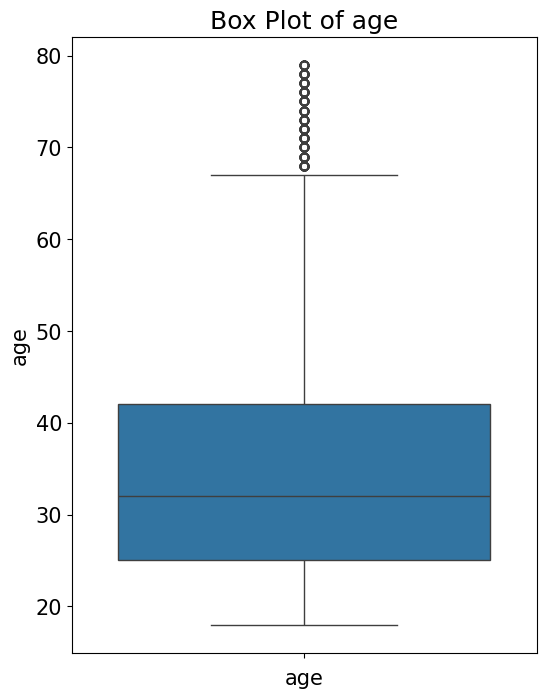

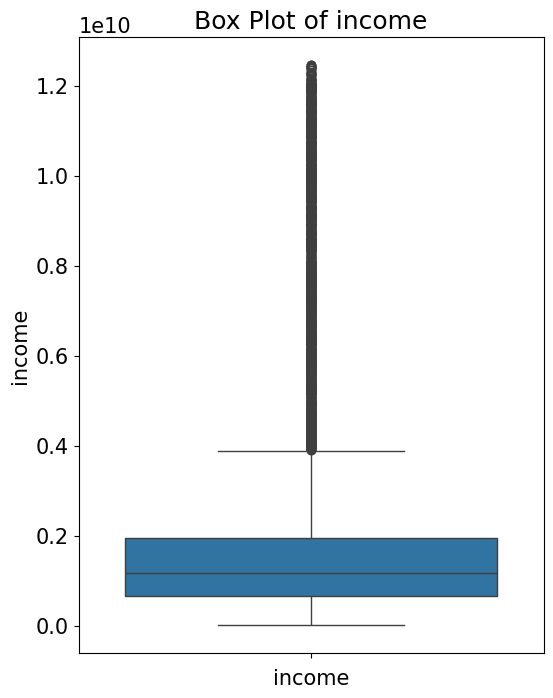

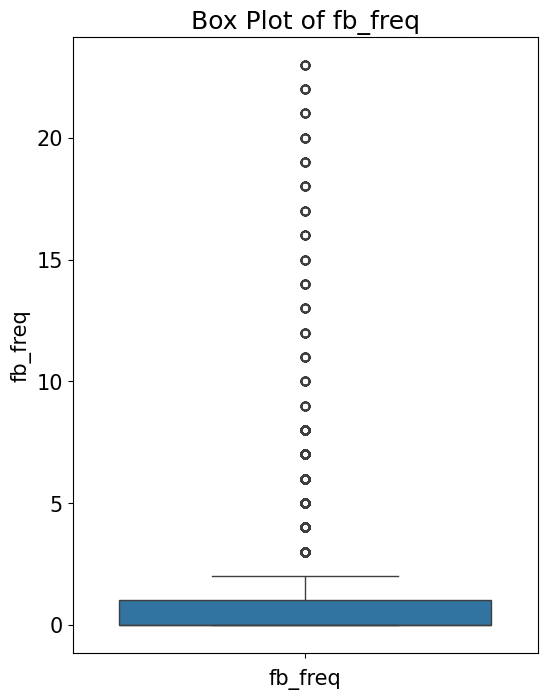

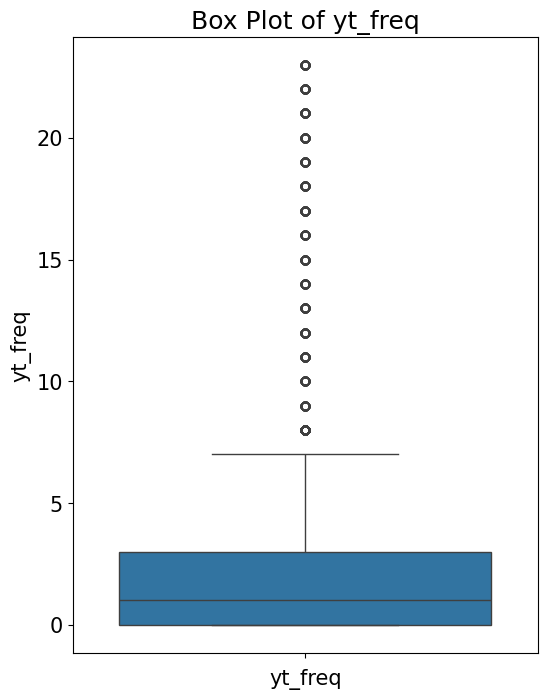

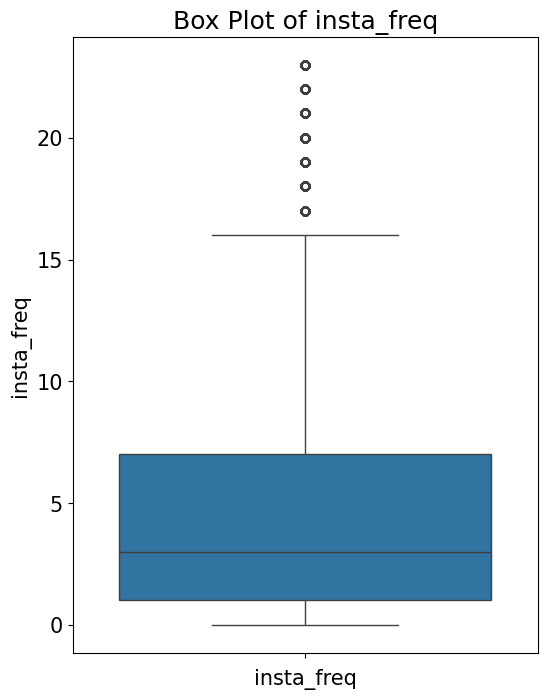

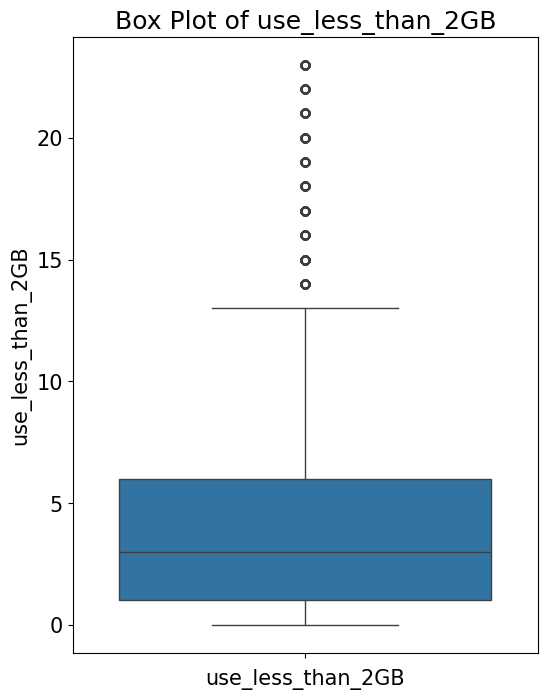

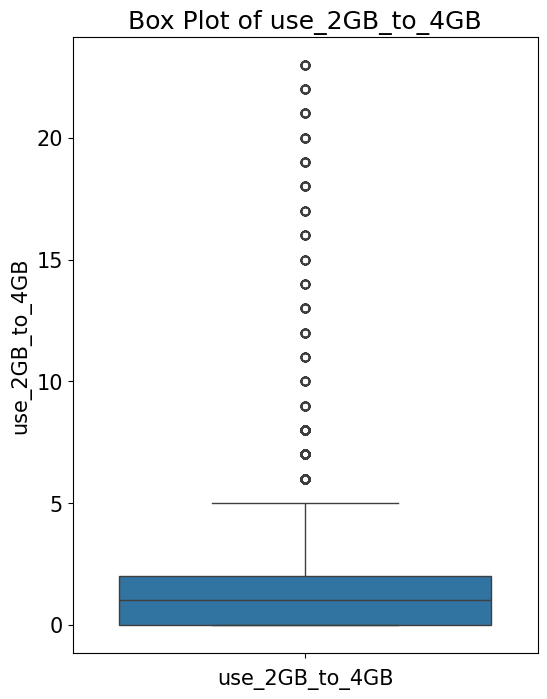

In [264]:
columns_to_plot = ['age', 'income', 'fb_freq', 'yt_freq', 'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB']

for column in columns_to_plot:
    fig, ax = plt.subplots(figsize=(6, 8))
    sns.boxplot(y=data_viz[column], ax=ax)
    ax.set_title(f'Box Plot of {column}')
    ax.set_xlabel(column)
    plt.show()

### 1. Demographic analyst

In [265]:
fig = go.Figure()
fig.update_layout(
    width=800,
    height=800,
    font_size=15
)


age_purchase_data = data_viz.groupby('age_quartile')['id'].count()

# Define the color scale
norm = plt.Normalize(vmin=age_purchase_data.min(), vmax=age_purchase_data.max())
colors = plt.cm.Purples(norm(age_purchase_data.values))

# Create the pie chart
fig.add_trace(go.Pie(
    labels=age_purchase_data.index,
    values=age_purchase_data,
    marker=dict(colors=['#075CF9', '#063FA7', '#05296B' , '#041D4A' ]),
    textinfo='label+percent',
    textposition='inside',
    textfont_size=25,
    insidetextorientation='horizontal',
    hoverinfo='label+percent+value',
))

# Add title
fig.update_layout(title="Count id by Age", legend_title="Age", height=600, width=600)

fig.show()

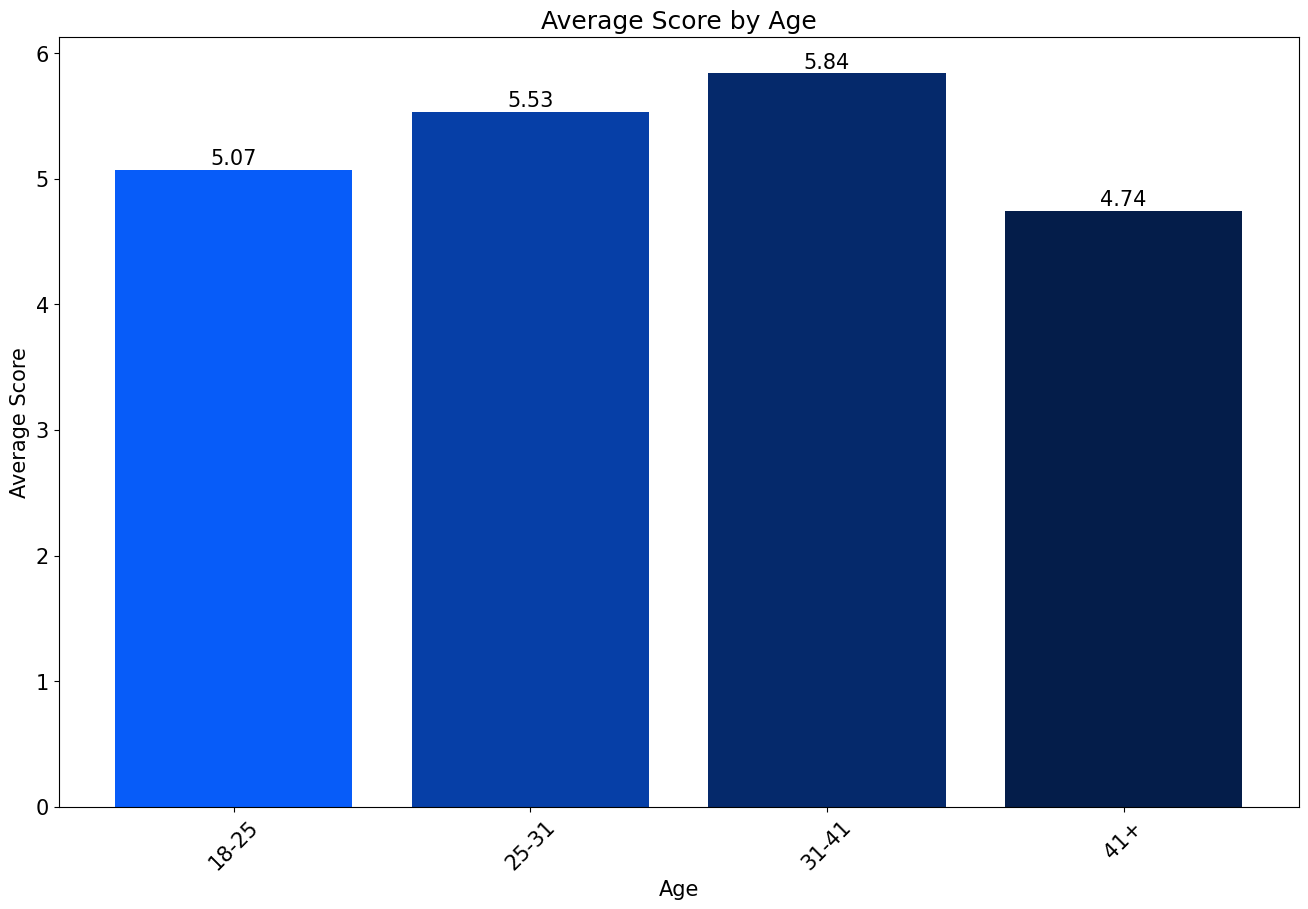

In [266]:
average_score_by_age = data_viz.groupby('age_quartile')['score'].mean()

plt.bar(average_score_by_age.index, average_score_by_age.values, color = ['#075CF9', '#063FA7', '#05296B' , '#041D4A' ])
plt.xlabel('Age')
plt.ylabel('Average Score')
plt.title('Average Score by Age')
plt.xticks(rotation=45)
# Remove the gridlines
plt.grid(False)

# Add data labels on top of each bar
for i, value in enumerate(average_score_by_age.values):
    plt.text(i, value + 0.01, round(value, 2), ha='center', va='bottom')

plt.show()

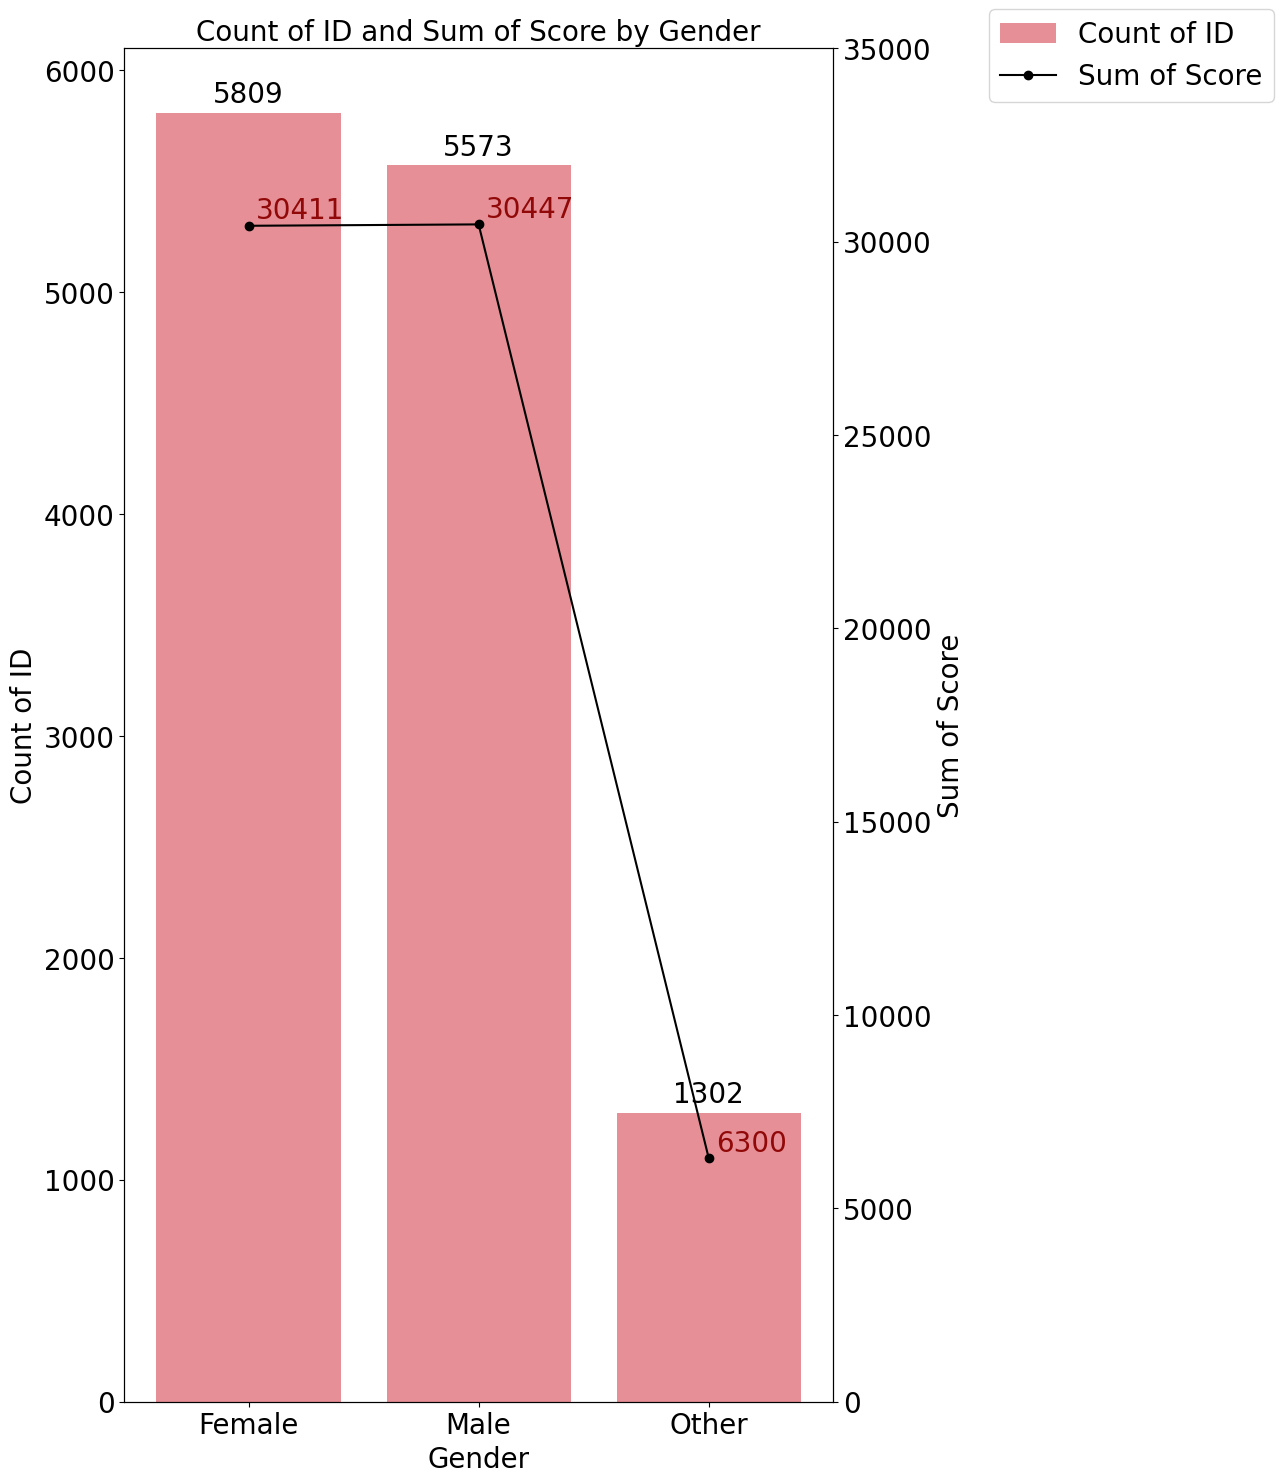

In [267]:
# Group by gender and calculate the count of IDs and sum of scores
grouped_data = data_viz.groupby('gender').agg(
    count_of_id=('id', 'count'),
    sum_of_score=('score', 'sum')
).reset_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 15))

# Bar plot for count of IDs
bars = ax1.bar(grouped_data['gender'], grouped_data['count_of_id'], color='#D64550', alpha=0.6, label='Count of ID')
ax1.set_xlabel('Gender', fontsize=20)
ax1.set_ylabel('Count of ID', color='#010101', fontsize=20)
ax1.tick_params(axis='y', labelcolor='#010101', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# Annotate the bars in the bar plot
for bar in bars:
    yval = bar.get_height()
    ax1.annotate(f'{yval}',
                 xy=(bar.get_x() + bar.get_width() / 2, yval),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords='offset points',
                 ha='center',
                 va='bottom',
                 color='#010101',
                 fontsize=20)  # Increase the font size

# Create a second y-axis to plot the sum of scores
ax2 = ax1.twinx()
ax2.plot(grouped_data['gender'], grouped_data['sum_of_score'], color='black', marker='o', label='Sum of Score')
ax2.set_ylabel('Sum of Score', color='#010101', fontsize=20)
ax2.tick_params(axis='y', labelcolor='#010101', labelsize=20)
ax2.set_ylim(0, 35000)  # Set the y-axis limit for sum_of_score

# Annotate the points in the line plot
for i in range(len(grouped_data)):
    ax2.annotate(f'{grouped_data["sum_of_score"][i]}',
                 xy=(grouped_data['gender'][i], grouped_data['sum_of_score'][i]),
                 xytext=(5, 5),
                 textcoords='offset points',
                 color='#900808',
                 fontsize=20)  # Increase the font size

# Titles and labels
plt.title('Count of ID and Sum of Score by Gender', fontsize=20)

# add legend
fig.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.3, 1.0))


# Show plot
fig.tight_layout()
plt.show()

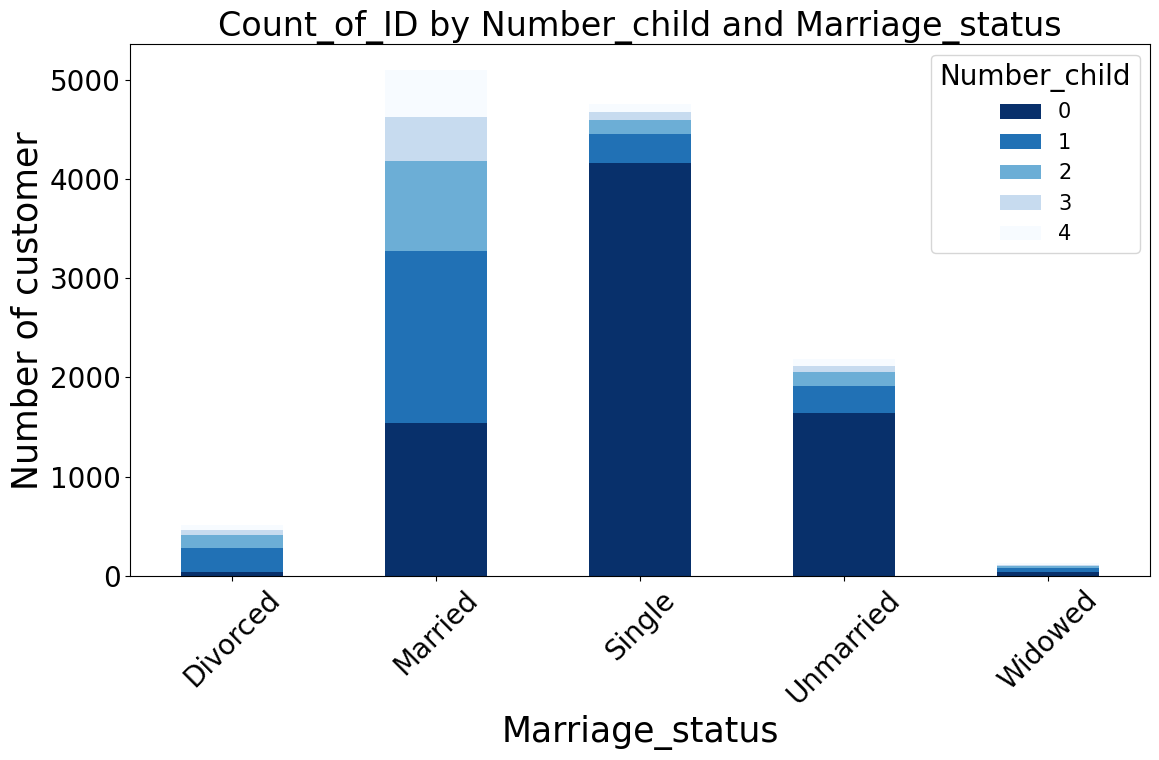

In [268]:
grouped_data = data_viz.groupby([ 'Marriage','Num_child'])['id'].count().unstack()
plt.rcParams['font.size'] = 20

cmap = plt.get_cmap('Blues_r')
colors = cmap(np.linspace(0, 1, grouped_data.shape[1]))
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)

plt.title('Count_of_ID by Number_child and Marriage_status')
plt.xlabel('Marriage_status', fontsize=25)
plt.ylabel('Number of customer', fontsize=25)
plt.legend(title='Number_child', fontsize=15)
plt.xticks(rotation=45)
# plt.grid(axis='y', alpha=0.7)

plt.tight_layout()
plt.savefig('Count_of_ID_by_Number_child_Marriage_status.png')
plt.show()

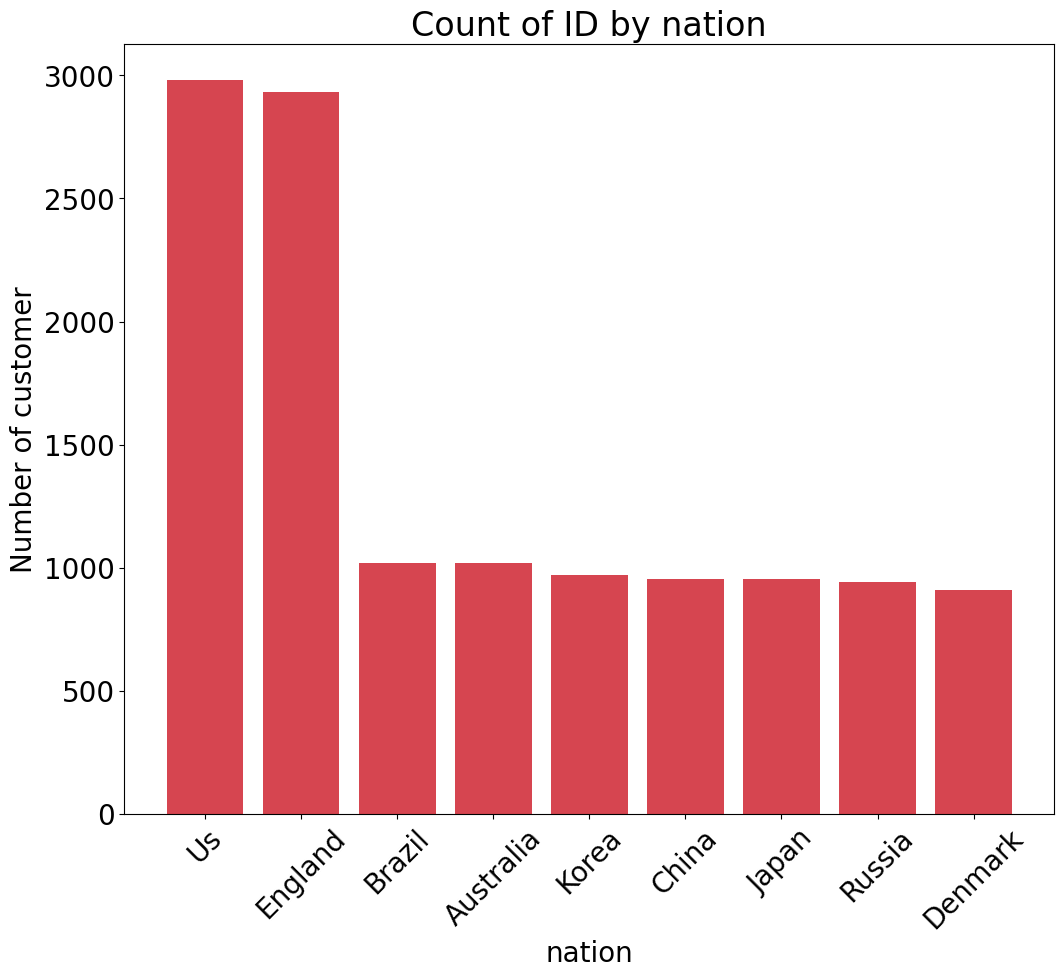

In [269]:
count_id_by_nation = data_viz.groupby('nation')['id'].count().sort_values(ascending=False)

plt.figure(figsize=(12, 10))

plt.bar(count_id_by_nation.index, count_id_by_nation.values, color = '#D64550')
plt.xlabel('nation')
plt.ylabel('Number of customer')
plt.title('Count of ID by nation')
plt.xticks(rotation=45)
# Remove the gridlines
plt.grid(False)


plt.show()

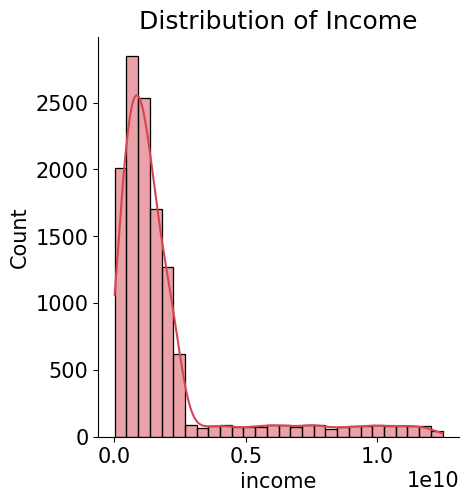

In [270]:
plt.rcParams['figure.figsize'] = (16,10)
plt.rcParams['font.size'] = 15
sns.displot(data=data_viz, x='income', kde=True, color='#D64550', bins=28)
plt.title('Distribution of Income')
plt.grid(False)
plt.show()

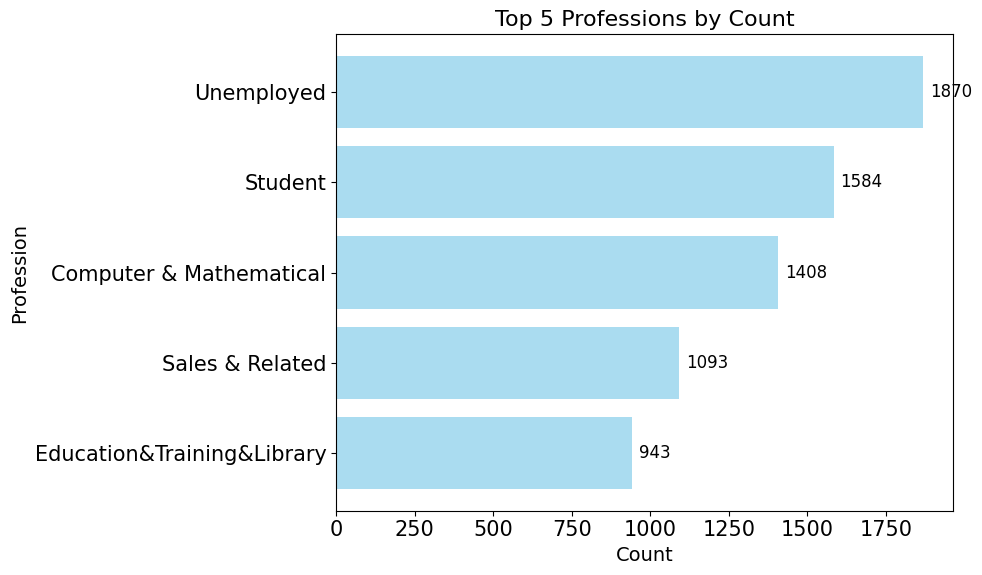

In [271]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the top 5 professions based on their counts
top_professions = data_viz['profession'].value_counts().nlargest(5).index
top_data_viz = data_viz[data_viz['profession'].isin(top_professions)]

# Create a DataFrame for plotting
top_profession_counts = top_data_viz['profession'].value_counts().sort_values()

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(top_profession_counts.index, top_profession_counts.values, color='skyblue', alpha=0.7)

# Annotate the bars with the counts
for bar in bars:
    plt.annotate(f'{bar.get_width()}', xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 xytext=(5, 0), textcoords='offset points', ha='left', va='center', fontsize=12)

# Labels and title
plt.xlabel('Count', fontsize=14)
plt.ylabel('Profession', fontsize=14)
plt.title('Top 5 Professions by Count', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


In [272]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Extract the top 5  based on their counts
# top_careers = data_viz['career'].value_counts().nlargest(5).index
# top_data_viz = data_viz[data_viz['career'].isin(top_careers)]

# # Create a DataFrame for plotting
# top_careers_counts = top_data_viz['career'].value_counts().sort_values()

# # Plotting
# plt.figure(figsize=(10, 6))
# bars = plt.barh(top_careers_counts.index, top_careers_counts.values, color='skyblue', alpha=0.7)

# # Annotate the bars with the counts
# for bar in bars:
#     plt.annotate(f'{bar.get_width()}', xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
#                  xytext=(5, 0), textcoords='offset points', ha='left', va='center', fontsize=12)

# # Labels and title
# plt.xlabel('Count', fontsize=14)
# plt.ylabel('Careers', fontsize=14)
# plt.title('Top 5 Careers by Count', fontsize=16)

# # Show the plot
# plt.tight_layout()
# plt.show()

### 2. Customer Behaviour analyst

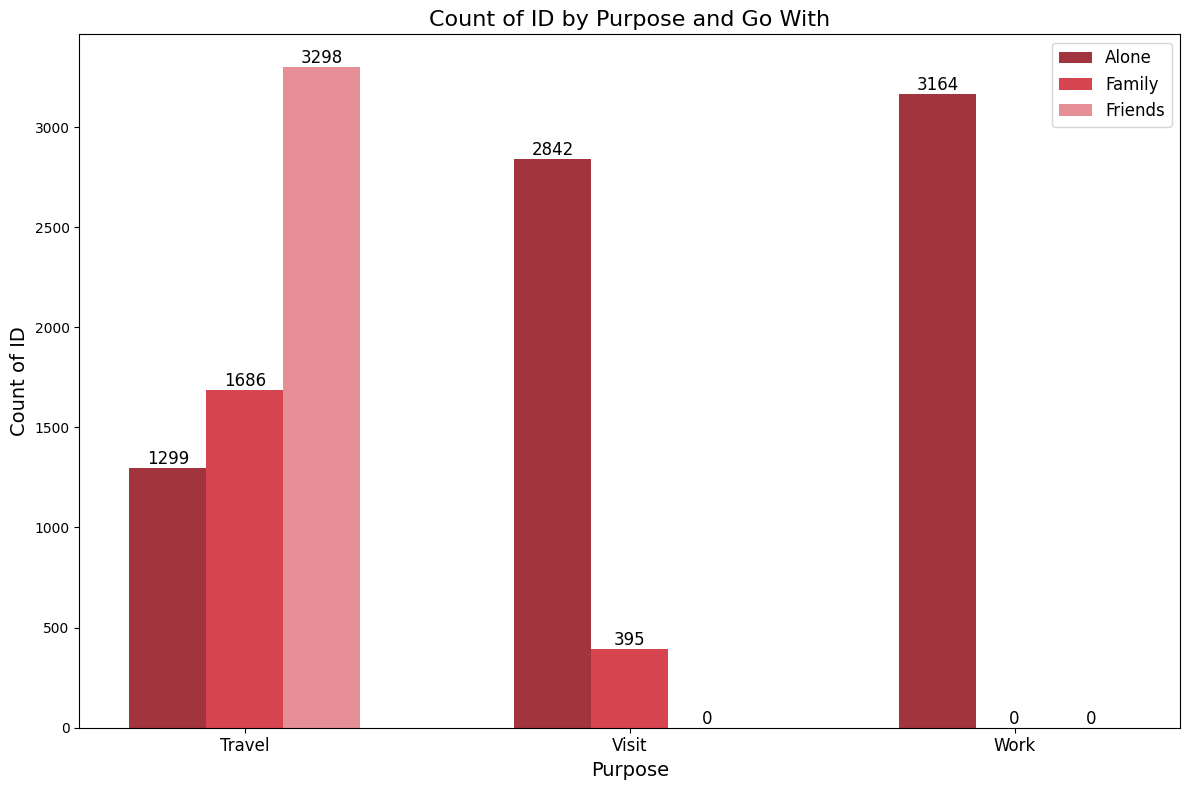

In [133]:
grouped_data = data_viz.groupby(['go_with', 'purpose' ]).size().reset_index(name='count_of_id')
pivot_data = grouped_data.pivot(index='go_with', columns='purpose', values='count_of_id').fillna(0)
fig, ax = plt.subplots(figsize=(12, 8))
num_categories = len(pivot_data.index)
bar_width = 0.2

colors = ['#A1343C', '#D64550', '#E68F96']

for i, (purpose, row) in enumerate(pivot_data.iterrows()):
    bar_positions = range(len(row))
    ax.bar([p + i * bar_width for p in bar_positions], row, width=bar_width, label=purpose,  color=colors[i % len(colors)])

ax.set_xlabel('Purpose', fontsize=14)
ax.set_ylabel('Count of ID', fontsize=14)
ax.set_title('Count of ID by Purpose and Go With', fontsize=16)
ax.set_xticks([p + (num_categories - 1) * bar_width / 2 for p in range(len(pivot_data.columns))])
ax.set_xticklabels(pivot_data.columns, fontsize=12)
ax.legend(fontsize=12)

# annotate the bars
for i, (purpose, row) in enumerate(pivot_data.iterrows()):
    for j, value in enumerate(row):
        ax.text(j + i * bar_width, value + 0.5, int(value), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

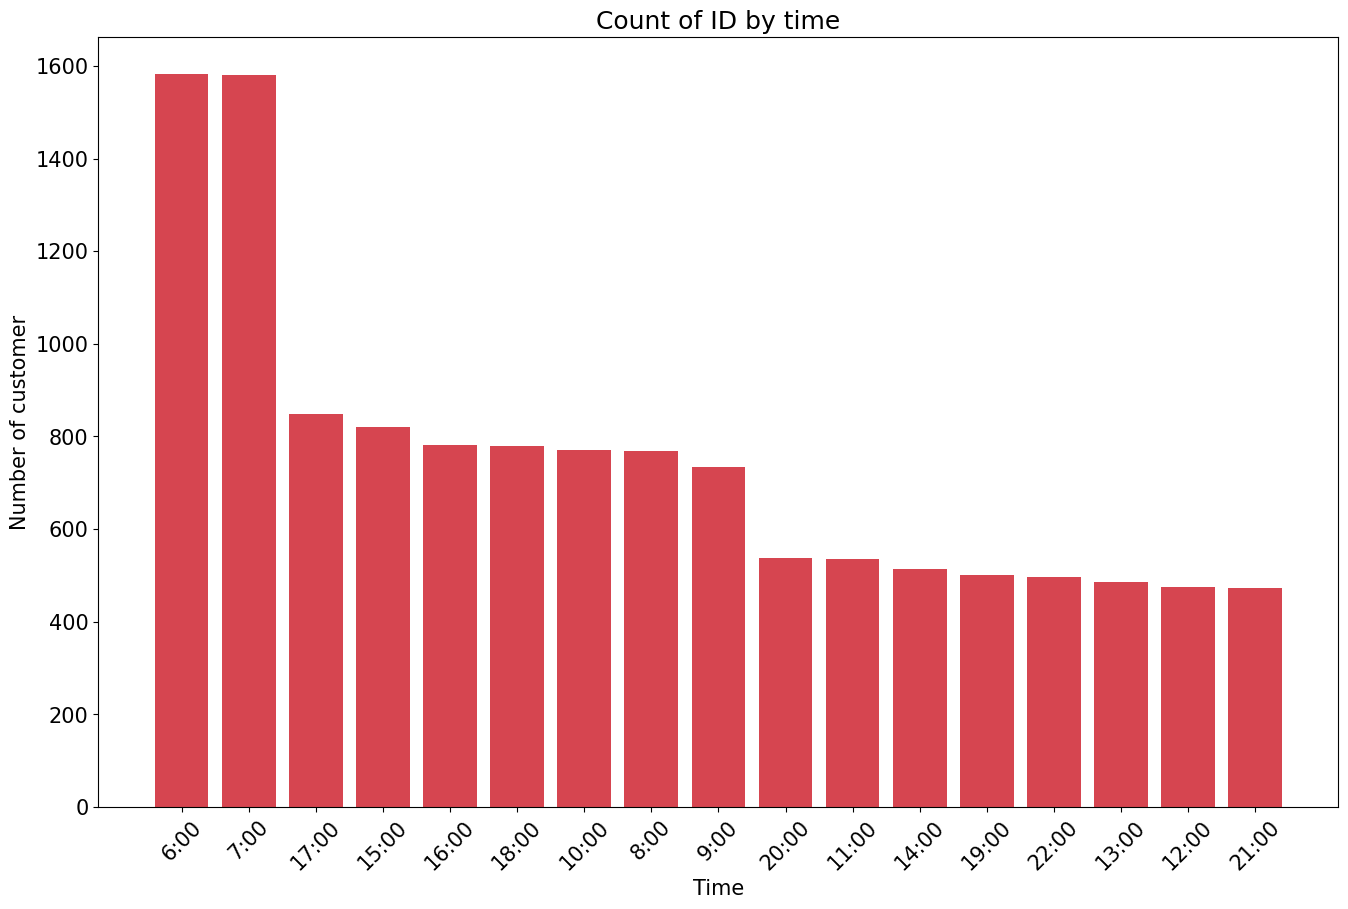

In [273]:
count_id_by_time = data_viz.groupby('time')['id'].count().sort_values(ascending=False)

plt.bar(count_id_by_time.index, count_id_by_time.values, color = '#D64550')
plt.xlabel('Time')
plt.ylabel('Number of customer')
plt.title('Count of ID by time')
plt.xticks(rotation=45)
# Remove the gridlines
plt.grid(False)


plt.show()

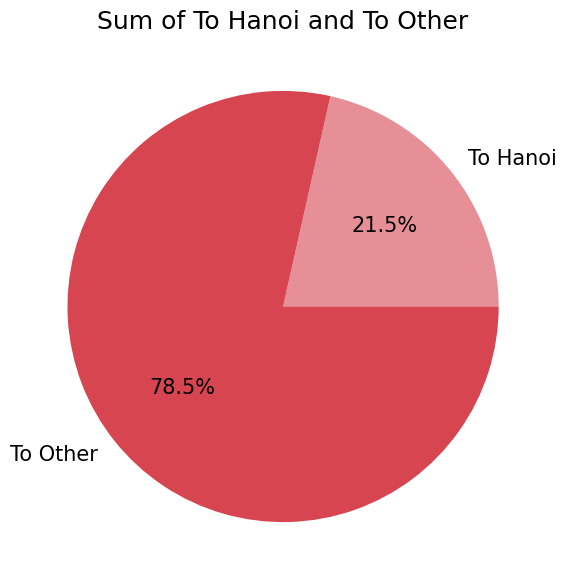

In [274]:
# Sum the values of 'to_hanoi' and 'to_other' columns
sum_to_hanoi = data_viz['to_hanoi'].sum()
sum_to_other = data_viz['to_other'].sum()

# Values for the pie chart
values = [sum_to_hanoi, sum_to_other]
labels = ['To Hanoi', 'To Other']

# Create the pie chart
plt.figure(figsize=(10, 7))
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=[ '#E68F96','#D64550'])
plt.title('Sum of To Hanoi and To Other')

# Show the plot
plt.show()

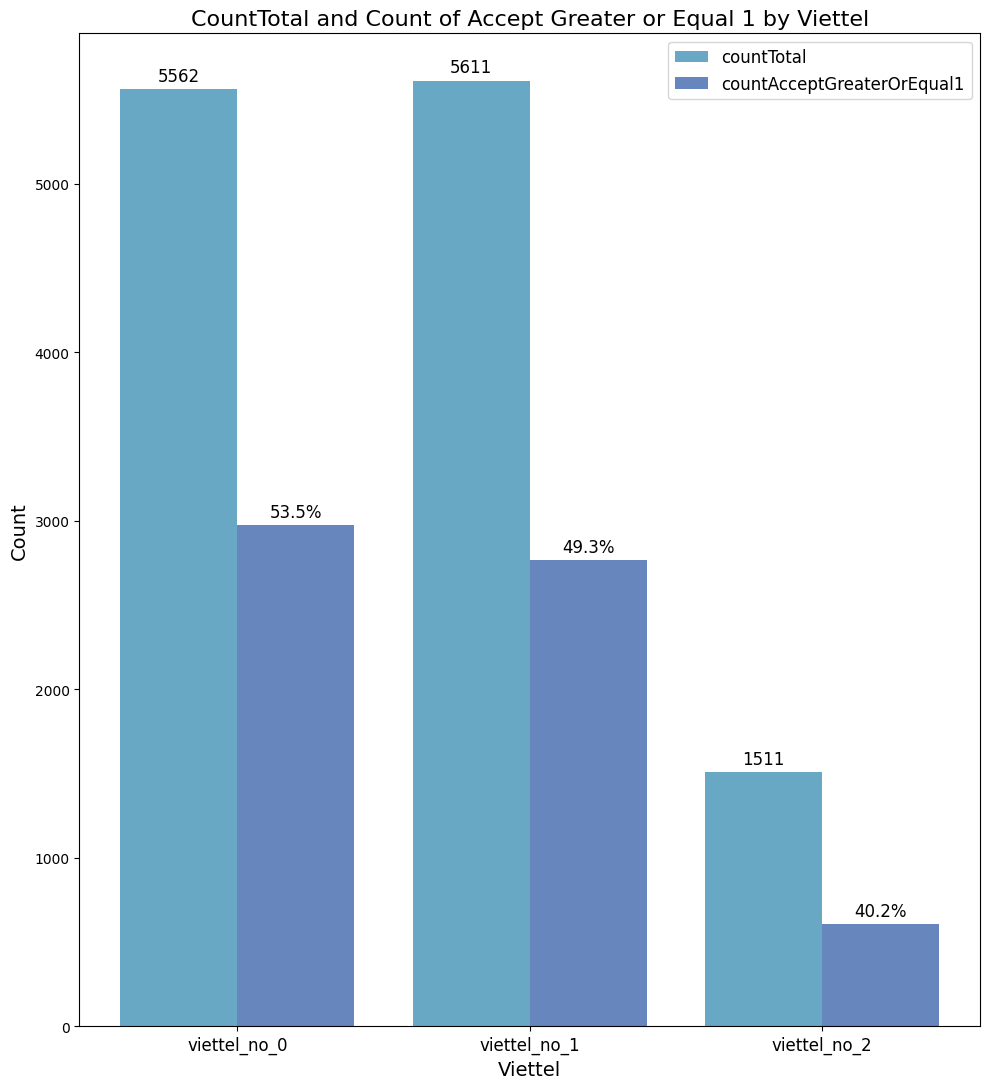

In [135]:
# CountTotal and Count of Accept Greater or Equal 1 by Viettel
viettel_no_0_countTotal = len(data_viz[data_viz['viettel_no_0'] == 1])
viettel_no_1_countTotal = len(data_viz[data_viz['viettel_no_1'] == 1])
viettel_no_2_countTotal = len(data_viz[data_viz['viettel_no_2'] == 1])

viettel_no_0_countAcceptGreaterOrEqual1 = len(data_viz[(data_viz['viettel_no_0'] == 1) & (data_viz['number_of_accept'] >= 1)])
viettel_no_1_countAcceptGreaterOrEqual1 = len(data_viz[(data_viz['viettel_no_1'] == 1) & (data_viz['number_of_accept'] >= 1)])
viettel_no_2_countAcceptGreaterOrEqual1 = len(data_viz[(data_viz['viettel_no_2'] == 1) & (data_viz['number_of_accept'] >= 1)])

# Prepare data for plotting
viettel_nos = ['viettel_no_0', 'viettel_no_1', 'viettel_no_2']
countTotal = [viettel_no_0_countTotal, viettel_no_1_countTotal, viettel_no_2_countTotal]
countAcceptGreaterOrEqual1 = [viettel_no_0_countAcceptGreaterOrEqual1, viettel_no_1_countAcceptGreaterOrEqual1, viettel_no_2_countAcceptGreaterOrEqual1]
percentAcceptGreaterOrEqual1 = [
    viettel_no_0_countAcceptGreaterOrEqual1 / viettel_no_0_countTotal * 100 if viettel_no_0_countTotal > 0 else 0,
    viettel_no_1_countAcceptGreaterOrEqual1 / viettel_no_1_countTotal * 100 if viettel_no_1_countTotal > 0 else 0,
    viettel_no_2_countAcceptGreaterOrEqual1 / viettel_no_2_countTotal * 100 if viettel_no_2_countTotal > 0 else 0
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 11))

bar_width = 0.4
index = range(len(viettel_nos))

bars1 = ax.bar(index, countTotal, bar_width, label='countTotal', color='#046E9F', alpha=0.6)
bars2 = ax.bar([i + bar_width for i in index], countAcceptGreaterOrEqual1, bar_width, label='countAcceptGreaterOrEqual1', color='#043693', alpha=0.6)

ax.set_xlabel('Viettel', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('CountTotal and Count of Accept Greater or Equal 1 by Viettel', fontsize=16)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(viettel_nos, fontsize=12)
ax.legend(fontsize=12)

# Annotate the bars with count numbers
for i, bar in enumerate(bars1):
    ax.annotate(f'{countTotal[i]}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords='offset points',
                ha='center',
                va='bottom',
                color='#010101',
                fontsize=12)


for i, bar in enumerate(bars2):
    ax.annotate(f'{percentAcceptGreaterOrEqual1[i]:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords='offset points',
                ha='center',
                va='bottom',
                color='#010101',
                fontsize=12)

plt.tight_layout()
plt.show()

### 3. Product analyst

In [275]:
train_mobile_plan_user = pd.read_csv('train_set/mobile_plan_user.csv')
test_mobile_plan_user = pd.read_csv('test_set/mobile_plan_user.csv')
test_mobile_plan_user = test_mobile_plan_user.rename(columns = {'coupon_id': 'mobile_plan'})
data_mobile_plan_user = pd.concat([train_mobile_plan_user , test_mobile_plan_user], axis=0)

In [276]:
data_mobile_plan_user = data_mobile_plan_user.dropna()


In [277]:
data_mobile_plan_user

,id,mobile_plan,accept
0,11156.0,DATASILVER,1.0
1,4297.0,SOCIALMEDIAGOLD,1.0
2,13301.0,DATASILVER,1.0
3,9920.0,SOCIALMEDIAGOLD,1.0
4,8424.0,DATASILVER,1.0
...,...,...,...
1383,14190.0,DATACALL,0.0
1385,16783.0,DATASILVER,0.0
1387,16954.0,DATACALL,0.0
1390,8037.0,SOCIALMEDIAGOLD,0.0


In [278]:
fig = go.Figure()
fig.update_layout(
    width=800,
    height=800,
    font_size=15
)

age_purchase_data = data_mobile_plan_user.groupby('mobile_plan')['accept'].sum().sort_values()

# Define the color scale
norm = plt.Normalize(vmin=age_purchase_data.min(), vmax=age_purchase_data.max())
colors = plt.cm.Purples(norm(age_purchase_data.values))

# Create the pie chart
fig.add_trace(go.Pie(
    labels=age_purchase_data.index,
    values=age_purchase_data,
    marker=dict(colors=[ '#A1343C','#E68F96', '#DE6A73','#EFB5B9','#D64550']),
    textinfo='label+percent',
    textposition='inside',
    textfont_size=25,
    insidetextorientation='horizontal',
    hoverinfo='label+percent+value',
))

# Add title
fig.update_layout(title="Count id by mobile_plant", legend_title="Mobile_plan", height=600, width=600)

fig.show()

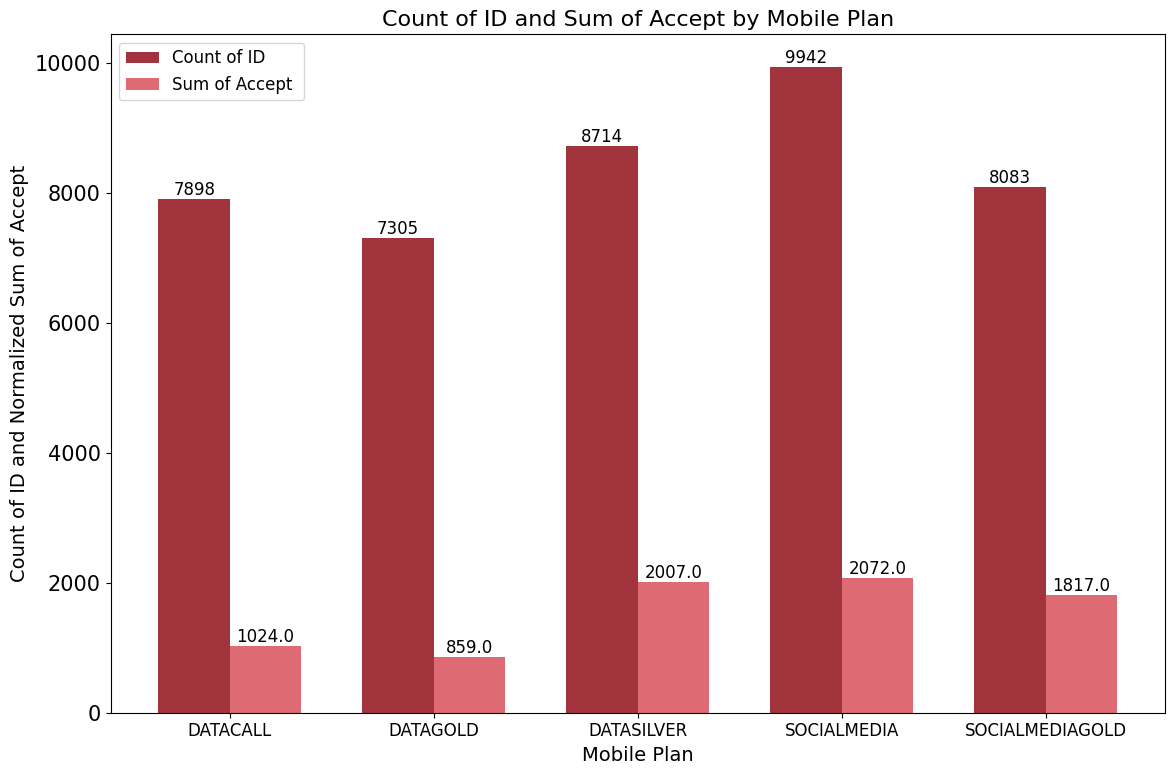

In [285]:

# Group by mobile_plan and calculate count of ids and sum of accept
grouped_data = data_mobile_plan_user.groupby('mobile_plan').agg(
    count_id=('id', 'count'),
    sum_accept=('accept', 'sum')
).reset_index()

# Normalize sum_accept to match the scale of count_id
max_count_id = grouped_data['count_id'].max()
max_sum_accept = grouped_data['sum_accept'].max()
grouped_data['normalized_sum_accept'] = grouped_data['sum_accept'] 

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Bar width and positions
bar_width = 0.35
index = np.arange(len(grouped_data['mobile_plan']))

# Bar plot for count of ids
bars1 = ax.bar(index, grouped_data['count_id'], bar_width, label='Count of ID', color='#A1343C')

# Bar plot for normalized sum of accept
bars2 = ax.bar(index + bar_width, grouped_data['normalized_sum_accept'], bar_width, label='Sum of Accept ', color='#DE6A73')

# Adding labels
ax.set_xlabel('Mobile Plan', fontsize=14)
ax.set_ylabel('Count of ID and Normalized Sum of Accept', fontsize=14)
ax.set_title('Count of ID and Sum of Accept by Mobile Plan', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(grouped_data['mobile_plan'], fontsize=12)
ax.legend(loc='upper left', fontsize=12)



# Annotate bars for count of id
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=12)

# Annotate bars for normalized sum of accept with original values
for i, bar in enumerate(bars2):
    yval = grouped_data['sum_accept'][i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{yval}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [288]:
# pie chart of count_id by number_of_accept_2 > 0
fig = go.Figure()
fig.update_layout(
    width=800,
    height=800,
    font_size=15
)

num_accept_2_id = data_viz[data_viz['number_of_accept_2'] > 0].groupby('number_of_accept_2')['id'].count().sort_values()

# Define the color scale
norm = plt.Normalize(vmin=num_accept_2_id.min(), vmax=num_accept_2_id.max())
colors = plt.cm.Purples(norm(num_accept_2_id.values))

# Create the pie chart
fig.add_trace(go.Pie(
    labels=num_accept_2_id.index,
    values=num_accept_2_id,
    marker=dict(colors=[ '#DE6A73','#EFB5B9','#D64550']),
    textinfo='label+percent',
    textposition='inside',
    textfont_size=25,
    insidetextorientation='horizontal',
    hoverinfo='label+percent+value',
))

# Add title
fig.update_layout(title="Count id by number_of_accept_2", legend_title="Number_of_accept_2", height=600, width=600)

fig.show()


In [290]:
# pie chart of count_id by number_of_accept
fig = go.Figure()
fig.update_layout(
    width=800,
    height=800,
    font_size=15
)

num_accept_2_id = data_viz.groupby('number_of_accept')['id'].count().sort_values()

# Define the color scale
norm = plt.Normalize(vmin=num_accept_2_id.min(), vmax=num_accept_2_id.max())
colors = plt.cm.Purples(norm(num_accept_2_id.values))

# Create the pie chart
fig.add_trace(go.Pie(
    labels=num_accept_2_id.index,
    values=num_accept_2_id,
    # marker=dict(colors=[ '#DE6A73','#EFB5B9','#D64550']),
    textinfo='label+percent',
    textposition='inside',
    textfont_size=25,
    insidetextorientation='horizontal',
    hoverinfo='label+percent+value',
))

# Add title
fig.update_layout(title="Count id by number_of_accept", legend_title="Number_of_accept", height=600, width=600)

fig.show()


In [292]:
data_viz.columns

Index(['id', 'name', 'gender', 'age', 'education', 'profession', 'income',
       'living_with', 'nation', 'phone', 'job', 'fb_freq', 'yt_freq',
       'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'Marriage',
       'Num_child', 'age_quartile', 'purpose', 'go_with', 'weather', 'time',
       'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other',
       'score', 'direction', 'number_of_suggestions', 'number_of_plans',
       'number_of_accept', 'number_of_accept_2', 'mobile_plan'],
      dtype='object')

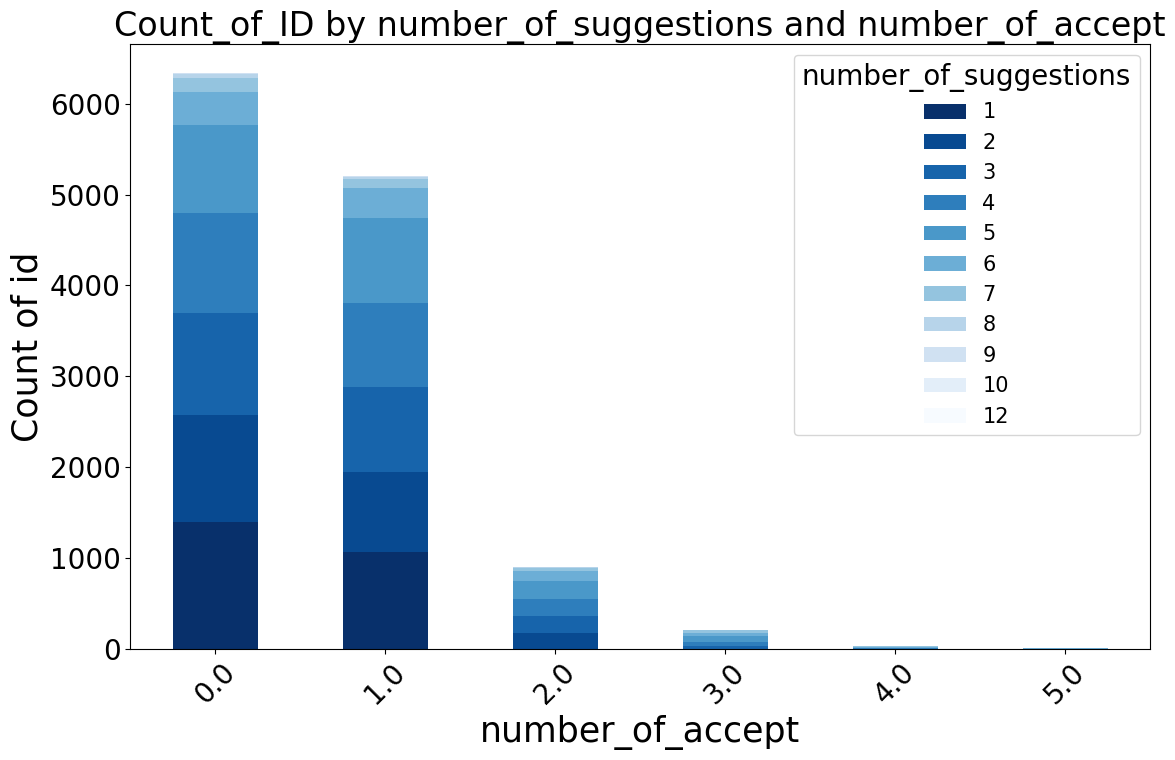

In [294]:
grouped_data = data_viz.groupby([ 'number_of_accept','number_of_suggestions'])['id'].count().unstack()
plt.rcParams['font.size'] = 20

cmap = plt.get_cmap('Blues_r')
colors = cmap(np.linspace(0, 1, grouped_data.shape[1]))
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)

plt.title('Count_of_ID by number_of_suggestions and number_of_accept')
plt.xlabel('number_of_accept', fontsize=25)
plt.ylabel('Count of id', fontsize=25)
plt.legend(title='number_of_suggestions', fontsize=15)
plt.xticks(rotation=45)
# plt.grid(axis='y', alpha=0.7)

plt.tight_layout()
plt.show()

# Models

## Method 1: Classification on 5 labels

In [153]:
df_train = pd.read_csv("clean/train_merge_cleaning.csv")
df_test = pd.read_csv("clean/test_merge_cleaning.csv")

In [154]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11572 entries, 0 to 11571
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     11572 non-null  int64  
 1   name                   11572 non-null  object 
 2   gender                 11572 non-null  object 
 3   age                    11572 non-null  int64  
 4   education              11572 non-null  object 
 5   profession             11572 non-null  object 
 6   income                 11572 non-null  int64  
 7   living_with            11572 non-null  object 
 8   nation                 11572 non-null  object 
 9   phone                  11572 non-null  int64  
 10  job                    11572 non-null  object 
 11  fb_freq                11572 non-null  int64  
 12  yt_freq                11572 non-null  int64  
 13  insta_freq             11572 non-null  int64  
 14  use_less_than_2GB      11572 non-null  int64  
 15  us

In [155]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1112 non-null   int64  
 1   name                   1112 non-null   object 
 2   gender                 1112 non-null   object 
 3   age                    1112 non-null   int64  
 4   education              1112 non-null   object 
 5   profession             1112 non-null   object 
 6   income                 1112 non-null   int64  
 7   living_with            1112 non-null   object 
 8   nation                 1112 non-null   object 
 9   phone                  1112 non-null   int64  
 10  job                    1112 non-null   object 
 11  fb_freq                1112 non-null   int64  
 12  yt_freq                1112 non-null   int64  
 13  insta_freq             1112 non-null   int64  
 14  use_less_than_2GB      1112 non-null   int64  
 15  use_

In [156]:
df_train['income']

0         844800000
1        1456800000
2        1958400000
3         792000000
4         505000000
            ...    
11567    1120000000
11568    1478400000
11569    1324800000
11570    1298400000
11571    5925600000
Name: income, Length: 11572, dtype: int64

In [157]:
def normalize_mobile_plan(sample):
    if sample['mobile_plan'] == 'Unknown':
        return 'Unknown'
    # if sample doesn't contain ',' return sample['mobile_plan']
    if ',' not in sample['mobile_plan']:
        return sample['mobile_plan']
    # if sample contains ',' return the first element
    return sample['mobile_plan'].split(',')[0]

# normalize_mobile_plan
df_train['mobile_plan_2'] = df_train.apply(normalize_mobile_plan, axis=1)
df_test['mobile_plan_2'] = df_test.apply(normalize_mobile_plan, axis=1)

In [158]:
df_train = df_train[(df_train['mobile_plan'] != 'Unknown') & (df_train['number_of_accept_2'] == 1)]
df_test = df_test[(df_test['mobile_plan'] != 'Unknown') & (df_test['number_of_accept_2'] == 1)]

In [159]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5382 entries, 0 to 11569
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     5382 non-null   int64  
 1   name                   5382 non-null   object 
 2   gender                 5382 non-null   object 
 3   age                    5382 non-null   int64  
 4   education              5382 non-null   object 
 5   profession             5382 non-null   object 
 6   income                 5382 non-null   int64  
 7   living_with            5382 non-null   object 
 8   nation                 5382 non-null   object 
 9   phone                  5382 non-null   int64  
 10  job                    5382 non-null   object 
 11  fb_freq                5382 non-null   int64  
 12  yt_freq                5382 non-null   int64  
 13  insta_freq             5382 non-null   int64  
 14  use_less_than_2GB      5382 non-null   int64  
 15  use_2GB_

In [160]:
df_test['gender'].value_counts()

gender
Female    467
Name: count, dtype: int64

In [161]:
df_train['freq'] = df_train['fb_freq'] + df_train['insta_freq'] + df_train['yt_freq']
df_test['freq'] = df_test['fb_freq'] + df_test['insta_freq'] + df_test['yt_freq']

In [162]:
# feature selection
def feature_selection_2(df):
  df_2 = df[['gender', 'age', 'education', 'income', 'fb_freq', 'yt_freq', 'insta_freq', 'freq', 'use_less_than_2GB',
                 'use_2GB_to_4GB', 'purpose', 'go_with', 'weather', 'time', 'viettel_no_0', 'viettel_no_1',
                 'viettel_no_2', 'to_hanoi', 'score', 'to_other', 'Marriage', 'Num_child', 'mobile_plan_2', 'age_quartile']].copy()

  df_2['education'] = df_2['education'].astype('category')
  df_2['purpose'] = df_2['purpose'].astype('category')
  df_2['go_with'] = df_2['go_with'].astype('category')
  df_2['weather'] = df_2['weather'].astype('category')
  df_2['Marriage'] = df_2['Marriage'].astype('category')

  return df_2

In [163]:
df_train_2 = feature_selection_2(df_train)
df_test_2 = feature_selection_2(df_test)

In [164]:
df_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5382 entries, 0 to 11569
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5382 non-null   object  
 1   age                5382 non-null   int64   
 2   education          5382 non-null   category
 3   income             5382 non-null   int64   
 4   fb_freq            5382 non-null   int64   
 5   yt_freq            5382 non-null   int64   
 6   insta_freq         5382 non-null   int64   
 7   freq               5382 non-null   int64   
 8   use_less_than_2GB  5382 non-null   int64   
 9   use_2GB_to_4GB     5382 non-null   int64   
 10  purpose            5382 non-null   category
 11  go_with            5382 non-null   category
 12  weather            5382 non-null   category
 13  time               5382 non-null   object  
 14  viettel_no_0       5382 non-null   int64   
 15  viettel_no_1       5382 non-null   int64   
 16  viettel_no

In [165]:
# Encode label for object type
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df_train_2.columns:
    if df_train_2[col].dtype == 'object' and col != 'mobile_plan_2':
        df_train_2[col] = le.fit_transform(df_train_2[col])
        df_test_2[col] = le.transform(df_test_2[col])  # Use the same encoder for test data
        print(col)

gender
time
age_quartile


In [166]:
# get dummies for categorical features (type = category, not object)
df_train_2 = pd.get_dummies(df_train_2, columns=['education', 'purpose', 'go_with', 'weather', 'Marriage'])
df_test_2 = pd.get_dummies(df_test_2, columns=['education', 'purpose', 'go_with', 'weather', 'Marriage'])

In [167]:
# turn bool to int
def bool_to_int(df):
    bool_columns = df.select_dtypes(include='bool').columns
    df[bool_columns] = df[bool_columns].astype(int)
    return df

In [168]:
df_train_2 = bool_to_int(df_train_2)
df_test_2 = bool_to_int(df_test_2)

In [169]:
X_train = df_train_2.drop('mobile_plan_2', axis=1)
y_train = df_train_2['mobile_plan_2']

X_test = df_test_2.drop('mobile_plan_2', axis=1)
y_test = df_test_2['mobile_plan_2']

In [170]:
df_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5382 entries, 0 to 11569
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   gender                5382 non-null   int32 
 1   age                   5382 non-null   int64 
 2   income                5382 non-null   int64 
 3   fb_freq               5382 non-null   int64 
 4   yt_freq               5382 non-null   int64 
 5   insta_freq            5382 non-null   int64 
 6   freq                  5382 non-null   int64 
 7   use_less_than_2GB     5382 non-null   int64 
 8   use_2GB_to_4GB        5382 non-null   int64 
 9   time                  5382 non-null   int32 
 10  viettel_no_0          5382 non-null   int64 
 11  viettel_no_1          5382 non-null   int64 
 12  viettel_no_2          5382 non-null   int64 
 13  to_hanoi              5382 non-null   int64 
 14  score                 5382 non-null   int64 
 15  to_other              5382 non-null   int6

In [171]:
df_test_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 467 entries, 1 to 1109
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   gender                467 non-null    int32 
 1   age                   467 non-null    int64 
 2   income                467 non-null    int64 
 3   fb_freq               467 non-null    int64 
 4   yt_freq               467 non-null    int64 
 5   insta_freq            467 non-null    int64 
 6   freq                  467 non-null    int64 
 7   use_less_than_2GB     467 non-null    int64 
 8   use_2GB_to_4GB        467 non-null    int64 
 9   time                  467 non-null    int32 
 10  viettel_no_0          467 non-null    int64 
 11  viettel_no_1          467 non-null    int64 
 12  viettel_no_2          467 non-null    int64 
 13  to_hanoi              467 non-null    int64 
 14  score                 467 non-null    int64 
 15  to_other              467 non-null    int64 

In [172]:
# Scale X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [173]:
# Apply RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [174]:
# predict
y_pred = rf_classifier.predict(X_test)

[[67 23 35  7  2]
 [13 97 13  1  6]
 [21 12 87  0  1]
 [ 3  7  7 21  5]
 [ 6  9  1  2 21]]


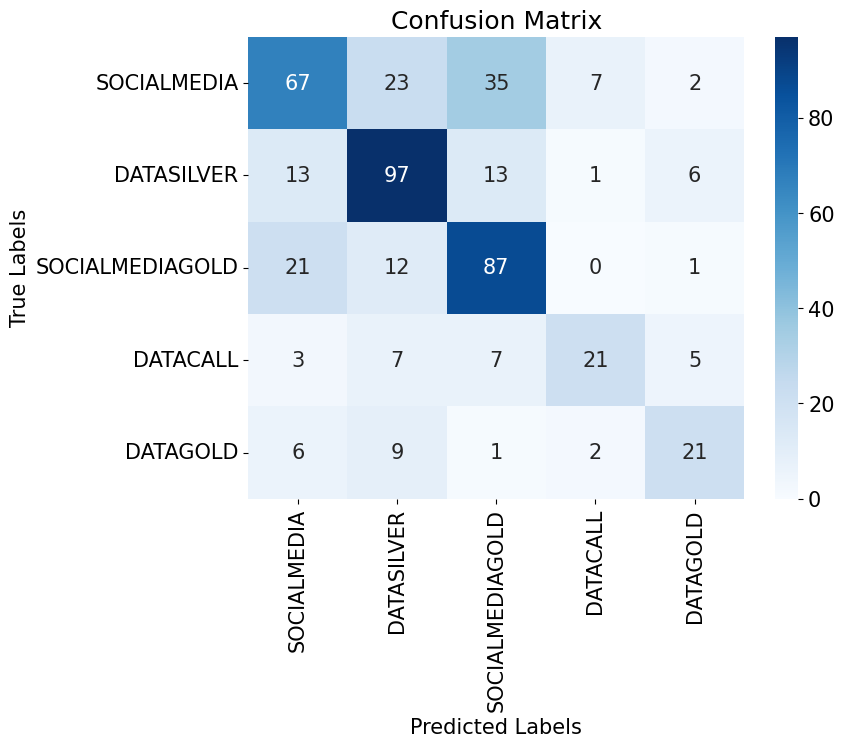

In [175]:
# show confusion matrix

from sklearn.metrics import confusion_matrix

labels = ['SOCIALMEDIA', 'DATASILVER', 'SOCIALMEDIAGOLD', 'DATACALL', 'DATAGOLD']

cm = confusion_matrix(y_test, y_pred, labels=labels)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [176]:
# show classification report
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, accuracy_score

print(classification_report(y_pred, y_test))

                 precision    recall  f1-score   support

       DATACALL       0.49      0.68      0.57        31
       DATAGOLD       0.54      0.60      0.57        35
     DATASILVER       0.75      0.66      0.70       148
    SOCIALMEDIA       0.50      0.61      0.55       110
SOCIALMEDIAGOLD       0.72      0.61      0.66       143

       accuracy                           0.63       467
      macro avg       0.60      0.63      0.61       467
   weighted avg       0.65      0.63      0.63       467



## Method 2: Binary classifier on each mobile_plan

In [177]:
df_train = pd.read_csv("clean/train_merge_cleaning.csv")
df_test = pd.read_csv("clean/test_merge_cleaning.csv")

In [178]:
# feature generation

df_train['freq'] = df_train['fb_freq'] + df_train['insta_freq'] + df_train['yt_freq']
df_test['freq'] = df_test['fb_freq'] + df_test['insta_freq'] + df_test['yt_freq']

In [179]:
# feature generation

income_q2 = df_train['income'].describe()['25%'].astype(int)
income_q3 = df_train['income'].describe()['50%'].astype(int)
income_q4 = df_train['income'].describe()['75%'].astype(int)

In [180]:
income_q4

1947825000

In [181]:
df_train['Smaller_than_6M'] = df_train['income'] < income_q2
df_train['6M_to_12M'] = (df_train['income'] >= income_q2) & (df_train['income'] < income_q3)
df_train['12M_to_20M'] = (df_train['income'] >= income_q3) & (df_train['income'] < income_q4)
df_train['Higher_than_20M'] = df_train['income'] >= income_q4

In [182]:
df_test['Smaller_than_6M'] = df_test['income'] < income_q2
df_test['6M_to_12M'] = (df_test['income'] >= income_q2) & (df_test['income'] < income_q3)
df_test['12M_to_20M'] = (df_test['income'] >= income_q3) & (df_test['income'] < income_q4)
df_test['Higher_than_20M'] = df_test['income'] >= income_q4

In [183]:
# Change directory

train_mobile_plan_user = pd.read_csv("train_set/mobile_plan_user.csv")
test_mobile_plan_user = pd.read_csv("test_set/mobile_plan_user.csv")
test_mobile_plan_user = test_mobile_plan_user.rename(columns={'coupon_id': 'mobile_plan'})

In [184]:
train_socialmedia =     train_mobile_plan_user[train_mobile_plan_user['mobile_plan'] == 'SOCIALMEDIA']
train_datasilver =      train_mobile_plan_user[train_mobile_plan_user['mobile_plan'] == 'DATASILVER']
train_socialmediagold = train_mobile_plan_user[train_mobile_plan_user['mobile_plan'] == 'SOCIALMEDIAGOLD']
train_datacall =        train_mobile_plan_user[train_mobile_plan_user['mobile_plan'] == 'DATACALL']
train_datagold =        train_mobile_plan_user[train_mobile_plan_user['mobile_plan'] == 'DATAGOLD']

In [185]:
test_socialmedia =     test_mobile_plan_user[test_mobile_plan_user['mobile_plan'] == 'SOCIALMEDIA']
test_datasilver =      test_mobile_plan_user[test_mobile_plan_user['mobile_plan'] == 'DATASILVER']
test_socialmediagold = test_mobile_plan_user[test_mobile_plan_user['mobile_plan'] == 'SOCIALMEDIAGOLD']
test_datacall =        test_mobile_plan_user[test_mobile_plan_user['mobile_plan'] == 'DATACALL']
test_datagold =        test_mobile_plan_user[test_mobile_plan_user['mobile_plan'] == 'DATAGOLD']

In [186]:
train_socialmedia_2 =     train_socialmedia.groupby(['id', 'mobile_plan']).sum().reset_index()
train_datasilver_2 =      train_datasilver.groupby(['id', 'mobile_plan']).sum().reset_index()
train_socialmediagold_2 = train_socialmediagold.groupby(['id', 'mobile_plan']).sum().reset_index()
train_datacall_2 =        train_datacall.groupby(['id', 'mobile_plan']).sum().reset_index()
train_datagold_2 =        train_datagold.groupby(['id', 'mobile_plan']).sum().reset_index()

In [187]:
test_socialmedia_2 =     test_socialmedia.groupby(['id', 'mobile_plan']).sum().reset_index()
test_datasilver_2 =      test_datasilver.groupby(['id', 'mobile_plan']).sum().reset_index()
test_socialmediagold_2 = test_socialmediagold.groupby(['id', 'mobile_plan']).sum().reset_index()
test_datacall_2 =        test_datacall.groupby(['id', 'mobile_plan']).sum().reset_index()
test_datagold_2 =        test_datagold.groupby(['id', 'mobile_plan']).sum().reset_index()

In [188]:
# turn into binary

train_socialmedia_2.loc[train_socialmedia_2['accept'] > 1, 'accept'] = 1
train_datasilver_2.loc[train_datasilver_2['accept'] > 1, 'accept'] = 1
train_socialmediagold_2.loc[train_socialmediagold_2['accept'] > 1, 'accept'] = 1
train_datacall_2.loc[train_datacall_2['accept'] > 1, 'accept'] = 1
train_datagold_2.loc[train_datagold_2['accept'] > 1, 'accept'] = 1

In [189]:
# turn into binary

test_socialmedia_2.loc[test_socialmedia_2['accept'] > 1, 'accept'] = 1
test_datasilver_2.loc[test_datasilver_2['accept'] > 1, 'accept'] = 1
test_socialmediagold_2.loc[test_socialmediagold_2['accept'] > 1, 'accept'] = 1
test_datacall_2.loc[test_datacall_2['accept'] > 1, 'accept'] = 1
test_datagold_2.loc[test_datagold_2['accept'] > 1, 'accept'] = 1

In [190]:
# merge to have features for prediction

train_socialmedia_2 = pd.merge(df_train, train_socialmedia_2.rename(columns={"mobile_plan": "plan"}), on = 'id', how = 'inner')
train_datasilver_2 = pd.merge(df_train, train_datasilver_2.rename(columns={"mobile_plan": "plan"}), on = 'id', how = 'inner')
train_socialmediagold_2 = pd.merge(df_train, train_socialmediagold_2.rename(columns={"mobile_plan": "plan"}), on = 'id', how = 'inner')
train_datacall_2 = pd.merge(df_train, train_datacall_2.rename(columns={"mobile_plan": "plan"}), on = 'id', how = 'inner')
train_datagold_2 = pd.merge(df_train, train_datagold_2.rename(columns={"mobile_plan": "plan"}), on = 'id', how = 'inner')

In [191]:
# merge to have features for prediction

test_socialmedia_2 = pd.merge(df_test, test_socialmedia_2.rename(columns={"mobile_plan": "plan"}), on = 'id', how = 'inner')
test_datasilver_2 = pd.merge(df_test, test_datasilver_2.rename(columns={"mobile_plan": "plan"}), on = 'id', how = 'inner')
test_socialmediagold_2 = pd.merge(df_test, test_socialmediagold_2.rename(columns={"mobile_plan": "plan"}), on = 'id', how = 'inner')
test_datacall_2 = pd.merge(df_test, test_datacall_2.rename(columns={"mobile_plan": "plan"}), on = 'id', how = 'inner')
test_datagold_2 = pd.merge(df_test, test_datagold_2.rename(columns={"mobile_plan": "plan"}), on = 'id', how = 'inner')

In [192]:
# feature selection

def feature_selection(df):
  df_2 = df[['gender', 'age', 'education', 'income', 'fb_freq', 'yt_freq', 'insta_freq', 'use_less_than_2GB',
                 'use_2GB_to_4GB', 'purpose', 'go_with', 'weather', 'time', 'viettel_no_0', 'viettel_no_1',
                 'viettel_no_2', 'to_hanoi', 'score', 'to_other', 'Marriage', 'Num_child', 'age_quartile', 'accept',
                 'freq', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M']].copy()

  df_2['education'] = df_2['education'].astype('category')
  df_2['purpose'] = df_2['purpose'].astype('category')
  df_2['go_with'] = df_2['go_with'].astype('category')
  df_2['weather'] = df_2['weather'].astype('category')
  df_2['Marriage'] = df_2['Marriage'].astype('category')

  return df_2

In [193]:
test_socialmedia_3 = feature_selection(test_socialmedia_2)
train_socialmedia_3 = feature_selection(train_socialmedia_2)

train_datasilver_3 = feature_selection(train_datasilver_2)
test_datasilver_3 = feature_selection(test_datasilver_2)

train_socialmediagold_3 = feature_selection(train_socialmediagold_2)
test_socialmediagold_3 = feature_selection(test_socialmediagold_2)

train_datacall_3 = feature_selection(train_datacall_2)
test_datacall_3 = feature_selection(test_datacall_2)

train_datagold_3 = feature_selection(train_datagold_2)
test_datagold_3 = feature_selection(test_datagold_2)

In [194]:
# Encode label for object type

le = LabelEncoder()
def encode_label(df_train, df_test):
    for col in df_train.columns:
        if df_train[col].dtype == 'object':
            df_train[col] = le.fit_transform(df_train[col])
            df_test[col] = le.transform(df_test[col])  # Use the same encoder for test data
            print(col)
    return df_train, df_test

In [195]:
train_socialmedia_3, test_socialmedia_3 = encode_label(train_socialmedia_3, test_socialmedia_3)
train_datasilver_3, test_datasilver_3 = encode_label(train_datasilver_3, test_datasilver_3)
train_socialmediagold_3, test_socialmediagold_3 = encode_label(train_socialmediagold_3, test_socialmediagold_3)
train_datacall_3, test_datacall_3 = encode_label(train_datacall_3, test_datacall_3)
train_datagold_3, test_datagold_3 = encode_label(train_datagold_3, test_datagold_3)

gender
time
age_quartile
gender
time
age_quartile
gender
time
age_quartile
gender
time
age_quartile
gender
time
age_quartile


In [196]:
# get dummies for categorical features (type = category, not object)

def get_dummies(df):
    df = pd.get_dummies(df, columns=['education', 'purpose', 'go_with', 'weather', 'Marriage'])
    return df

In [197]:
train_socialmedia_3 = get_dummies(train_socialmedia_3)
test_socialmedia_3 = get_dummies(test_socialmedia_3)

train_datasilver_3 = get_dummies(train_datasilver_3)
test_datasilver_3 = get_dummies(test_datasilver_3)

train_socialmediagold_3 = get_dummies(train_socialmediagold_3)
test_socialmediagold_3 = get_dummies(test_socialmediagold_3)

train_datacall_3 = get_dummies(train_datacall_3)
test_datacall_3 = get_dummies(test_datacall_3)

train_datagold_3 = get_dummies(train_datagold_3)
test_datagold_3 = get_dummies(test_datagold_3)

In [198]:
# turn bool to int
def bool_to_int(df):
    bool_columns = df.select_dtypes(include='bool').columns
    df[bool_columns] = df[bool_columns].astype(int)
    return df

In [199]:
train_socialmedia_3 = bool_to_int(train_socialmedia_3)
test_socialmedia_3 = bool_to_int(test_socialmedia_3)

train_datasilver_3 = bool_to_int(train_datasilver_3)
test_datasilver_3 = bool_to_int(test_datasilver_3)

train_socialmediagold_3 = bool_to_int(train_socialmediagold_3)
test_socialmediagold_3 = bool_to_int(test_socialmediagold_3)

train_datacall_3 = bool_to_int(train_datacall_3)
test_datacall_3 = bool_to_int(test_datacall_3)

train_datagold_3 = bool_to_int(train_datagold_3)
test_datagold_3 = bool_to_int(test_datagold_3)

In [200]:
train_socialmedia_3.columns

Index(['gender', 'age', 'income', 'fb_freq', 'yt_freq', 'insta_freq',
       'use_less_than_2GB', 'use_2GB_to_4GB', 'time', 'viettel_no_0',
       'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'score', 'to_other',
       'Num_child', 'age_quartile', 'accept', 'freq', 'Smaller_than_6M',
       '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'education_Associate',
       'education_Bachelor', 'education_Highschool', 'education_Masters',
       'education_Unknown', 'purpose_Travel', 'purpose_Visit', 'purpose_Work',
       'go_with_Alone', 'go_with_Family', 'go_with_Friends', 'weather_Rainy',
       'weather_Snowy', 'weather_Sunny', 'Marriage_Divorced',
       'Marriage_Married', 'Marriage_Single', 'Marriage_Unmarried',
       'Marriage_Widowed'],
      dtype='object')

## SocialMedia

#### 1. No downsampling

In [201]:
X_train = train_socialmedia_3.drop('accept', axis=1)
y_train = train_socialmedia_3['accept']

X_test = test_socialmedia_3.drop('accept', axis=1)
y_test = test_socialmedia_3['accept']

In [202]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression score: 0.5484848484848485


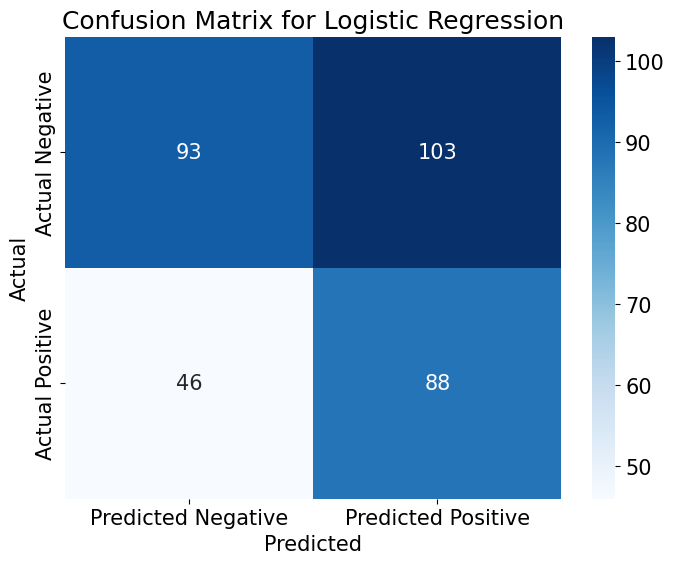

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.47      0.56       196
         1.0       0.46      0.66      0.54       134

    accuracy                           0.55       330
   macro avg       0.56      0.57      0.55       330
weighted avg       0.58      0.55      0.55       330

F1 Score: 0.5496667710399054
ROC AUC Score: 0.5656031069144076


In [203]:
# Using Logistic Regression to predict

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

lr_score = lr.score(X_test, y_test)
print("Logistic Regression score:", lr_score)

y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# roc score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)


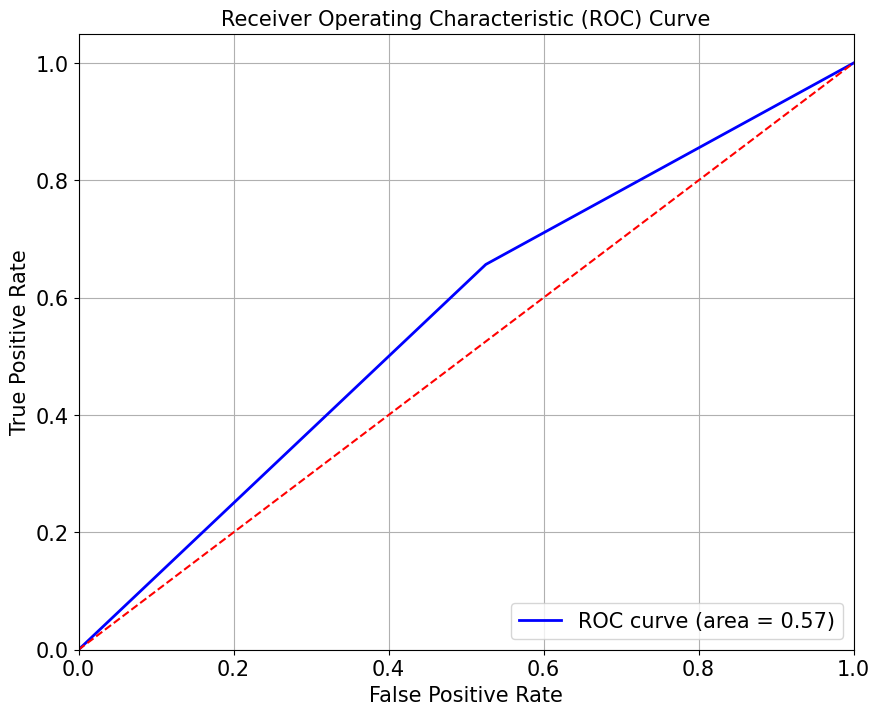

In [204]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

SVM score: 0.6121212121212121


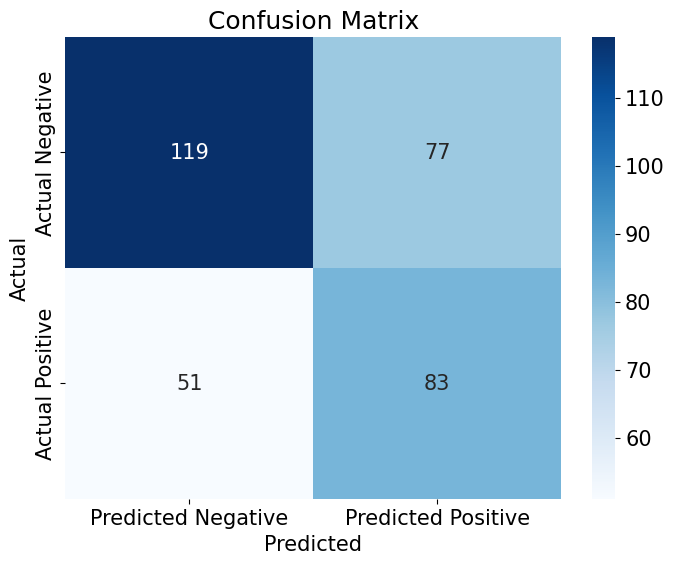

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.61      0.65       196
         1.0       0.52      0.62      0.56       134

    accuracy                           0.61       330
   macro avg       0.61      0.61      0.61       330
weighted avg       0.63      0.61      0.62       330

F1 Score: 0.615495199570141
ROC AUC Score: 0.613272921108742


In [205]:
# Using SVM to predict

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

svm = SVC(class_weight='balanced')
svm.fit(X_train, y_train)

svm_score = svm.score(X_test, y_test)
print("SVM score:", svm_score)

y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# roc score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

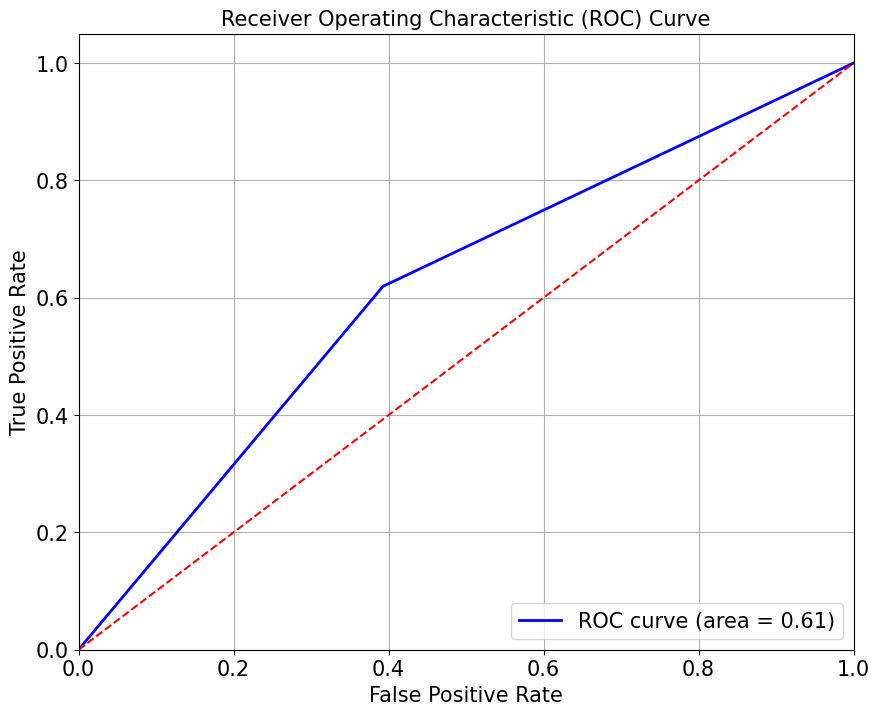

In [206]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

RF score: 0.6242424242424243


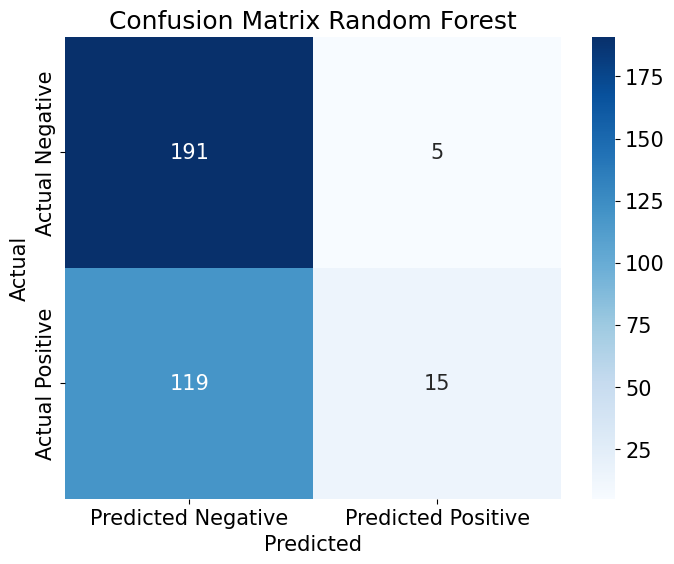

Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.97      0.75       196
         1.0       0.75      0.11      0.19       134

    accuracy                           0.62       330
   macro avg       0.68      0.54      0.47       330
weighted avg       0.67      0.62      0.53       330

F1 Score: 0.5274917440925345
ROC AUC Score: 0.5432150472129151


In [207]:
# Using Random Forest to predict

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_score = rf.score(X_test, y_test)
print("RF score:", rf_score)

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Random Forest')
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# roc score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

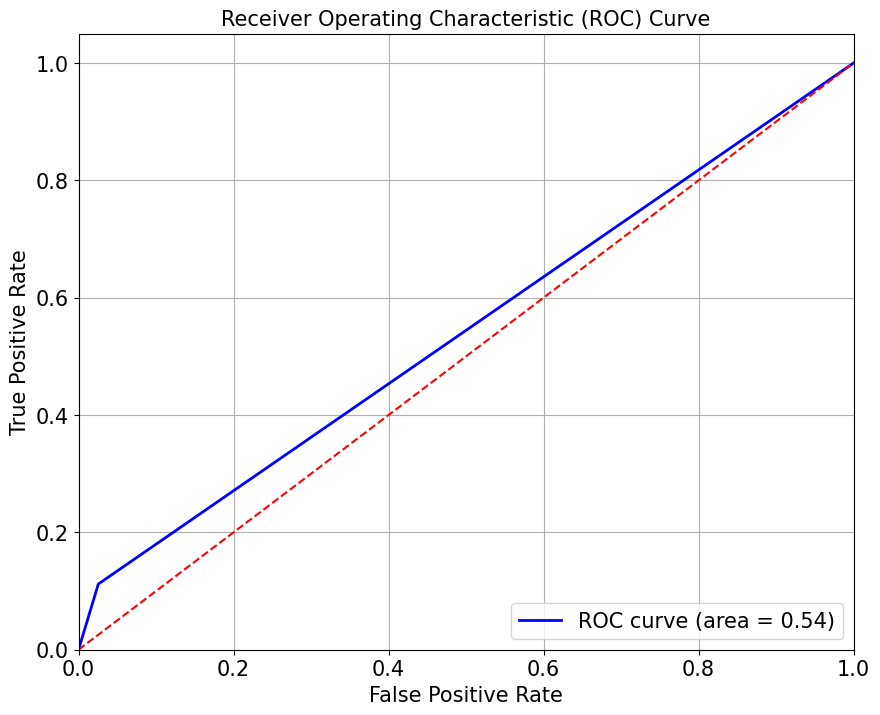

In [208]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

In [209]:
# Using LightGBM to predict

import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

lgb_model = lgb.LGBMClassifier(
                        objective='binary',
                        metrics='binary_logloss',
                        learning_rate=0.1,   # Giảm tốc độ học
                        max_depth=8,          # Độ sâu cây
                        num_leaves=8,        # Số lá
                        reg_alpha=0.05,        # Regularization term alpha
                        reg_lambda=0.05,       # Regularization term lambda
                        n_estimators=512,     # Số lượng cây
                        verbosity=-1
                        )

lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

print(classification_report(y_test, y_pred))

Accuracy: 0.6242424242424243
Weighted F1 Score: 0.5412996542849288
ROC AUC Score: 0.5479363387145904
              precision    recall  f1-score   support

         0.0       0.62      0.95      0.75       196
         1.0       0.68      0.14      0.23       134

    accuracy                           0.62       330
   macro avg       0.65      0.55      0.49       330
weighted avg       0.64      0.62      0.54       330



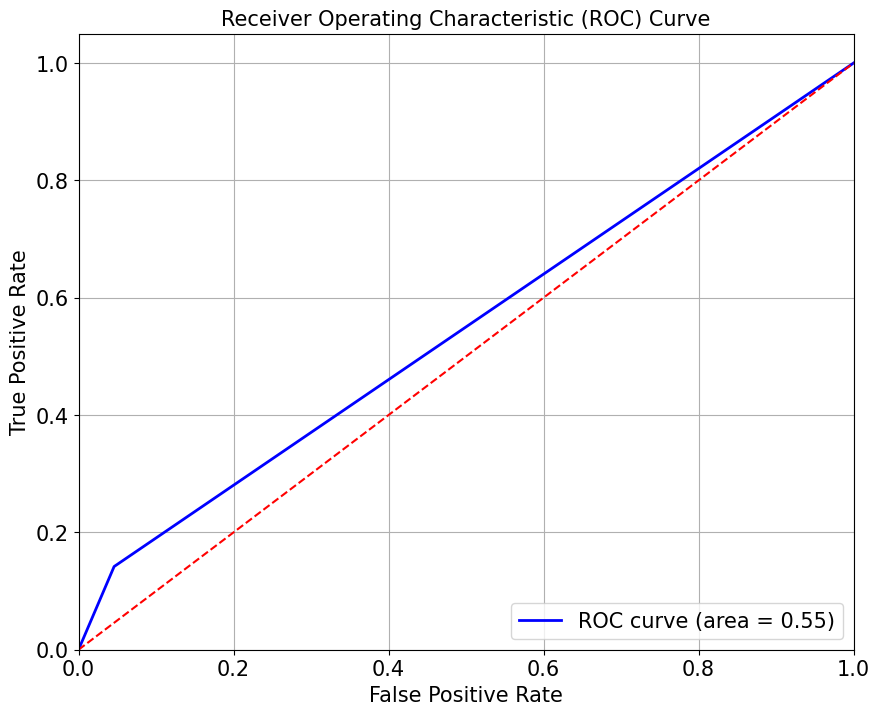

In [210]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

In [211]:
# Using XGBoost to predict

import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb


xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    max_depth=1,
    n_estimators=1024,
    reg_alpha=0.05,
    reg_lambda=0.05,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

print(classification_report(y_test, y_pred))

Accuracy: 0.6
Weighted F1 Score: 0.45626403233048946
ROC AUC Score: 0.5074626865671642
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75       196
         1.0       1.00      0.01      0.03       134

    accuracy                           0.60       330
   macro avg       0.80      0.51      0.39       330
weighted avg       0.76      0.60      0.46       330



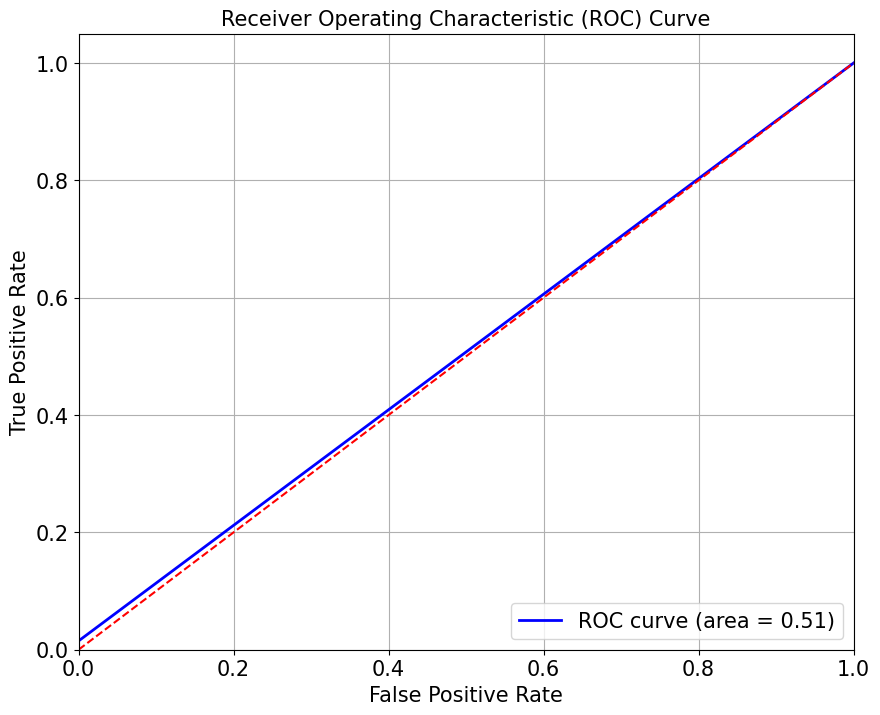

In [212]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

In [213]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Ensure that X_train and X_test are DataFrames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Ensure that the data is numeric and has no missing values
X_train = X_train.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)  # .values to ensure numpy array
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)  # .values to ensure numpy array

# Define the ANN model
class ANN(nn.Module):
    def __init__(self, n_features, n_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Create the model, loss function, and optimizer
model = ANN(n_features=X_train.shape[1], n_classes=len(torch.unique(y_train)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted == y_test).sum().item()
    print(f'Test Accuracy: {(correct / total) * 100:.2f}%')

# Get predictions on the test set
# y_pred = outputs.detach().numpy()

# Optionally, if you want to get the predicted class labels instead of probabilities:
y_pred = predicted.detach().numpy()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

print(classification_report(y_test, y_pred))

Epoch [10/100], Loss: 0.6382
Epoch [20/100], Loss: 0.5944
Epoch [30/100], Loss: 0.5654
Epoch [40/100], Loss: 0.5540
Epoch [50/100], Loss: 0.5505
Epoch [60/100], Loss: 0.5491
Epoch [70/100], Loss: 0.5480
Epoch [80/100], Loss: 0.5471
Epoch [90/100], Loss: 0.5463
Epoch [100/100], Loss: 0.5456
Test Accuracy: 59.39%
Accuracy: 0.593939393939394
Weighted F1 Score: 0.4426316395898145
ROC AUC Score: 0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.75       196
           1       0.00      0.00      0.00       134

    accuracy                           0.59       330
   macro avg       0.30      0.50      0.37       330
weighted avg       0.35      0.59      0.44       330



d:\study 6\DRAFT\DAZONE\Vong_3\dazonenv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\study 6\DRAFT\DAZONE\Vong_3\dazonenv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\study 6\DRAFT\DAZONE\Vong_3\dazonenv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



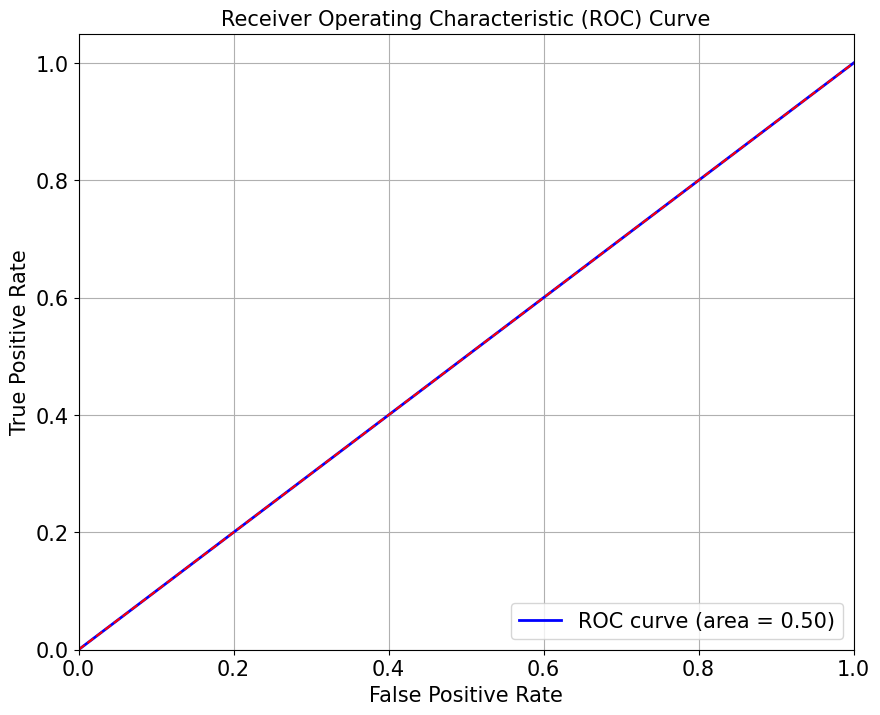

In [214]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

### After downsampling

In [215]:
X_train = train_socialmedia_3.drop('accept', axis=1)
y_train = train_socialmedia_3['accept']

X_test = test_socialmedia_3.drop('accept', axis=1)
y_test = test_socialmedia_3['accept']

In [216]:
# Downsampling

from sklearn.utils import resample
import pandas as pd

train_df = pd.concat([X_train, y_train], axis=1)

class_0 = train_df[train_df['accept'] == 0.0]
class_1 = train_df[train_df['accept'] == 1.0]

class_0_downsampled = resample(class_0,
                               replace=False,
                               n_samples=len(class_1),
                               random_state=42)

downsampled_df = pd.concat([class_0_downsampled, class_1])

X_train = downsampled_df.drop('accept', axis=1)
y_train = downsampled_df['accept']

print(y_train.value_counts())

accept
0.0    1685
1.0    1685
Name: count, dtype: int64


In [217]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression score: 0.5818181818181818


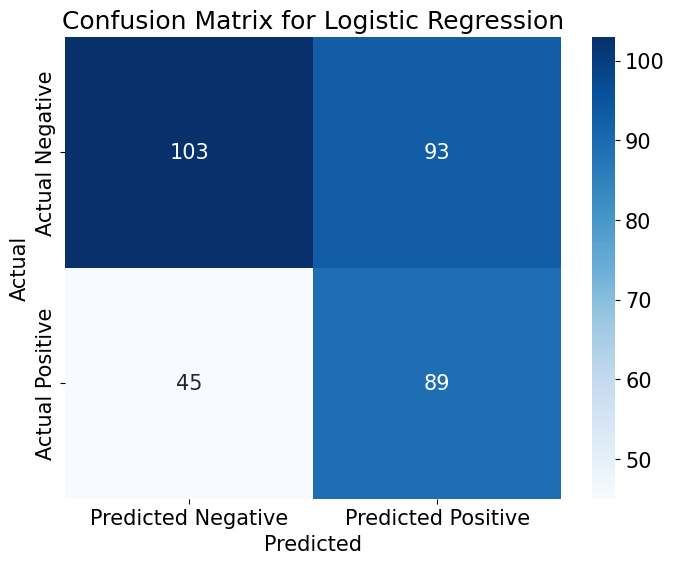

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.53      0.60       196
         1.0       0.49      0.66      0.56       134

    accuracy                           0.58       330
   macro avg       0.59      0.59      0.58       330
weighted avg       0.61      0.58      0.58       330

F1 Score: 0.5844033505499505
ROC AUC Score: 0.5948446542796223


In [218]:
# Downsampling + LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

lr_score = lr.score(X_test, y_test)
print("Logistic Regression score:", lr_score)

y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# roc score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)


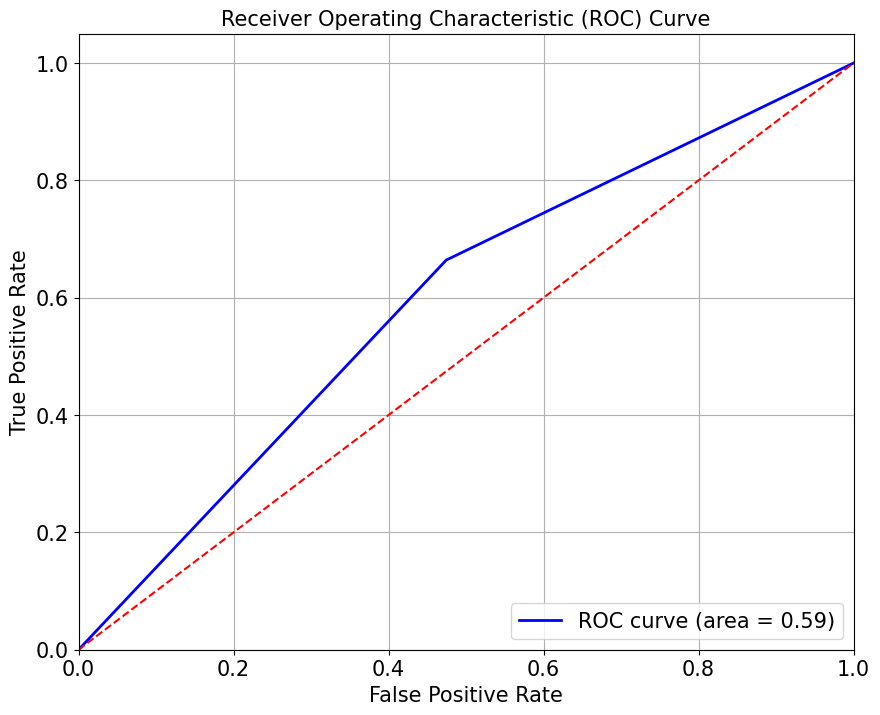

In [219]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

SVM score: 0.5909090909090909


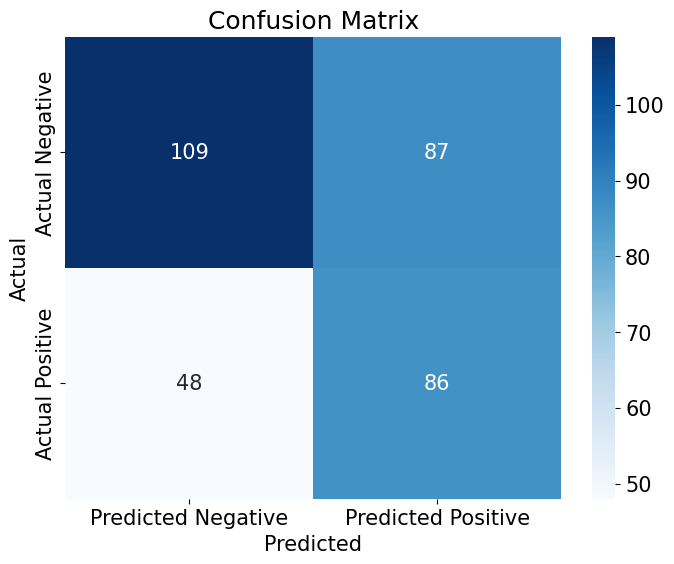

Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.56      0.62       196
         1.0       0.50      0.64      0.56       134

    accuracy                           0.59       330
   macro avg       0.60      0.60      0.59       330
weighted avg       0.61      0.59      0.59       330

F1 Score: 0.5942951863170371
ROC AUC Score: 0.5989567468778556


In [220]:
# Downsampling + SVM

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

svm = SVC(class_weight='balanced')
svm.fit(X_train, y_train)

svm_score = svm.score(X_test, y_test)
print("SVM score:", svm_score)

y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# roc score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

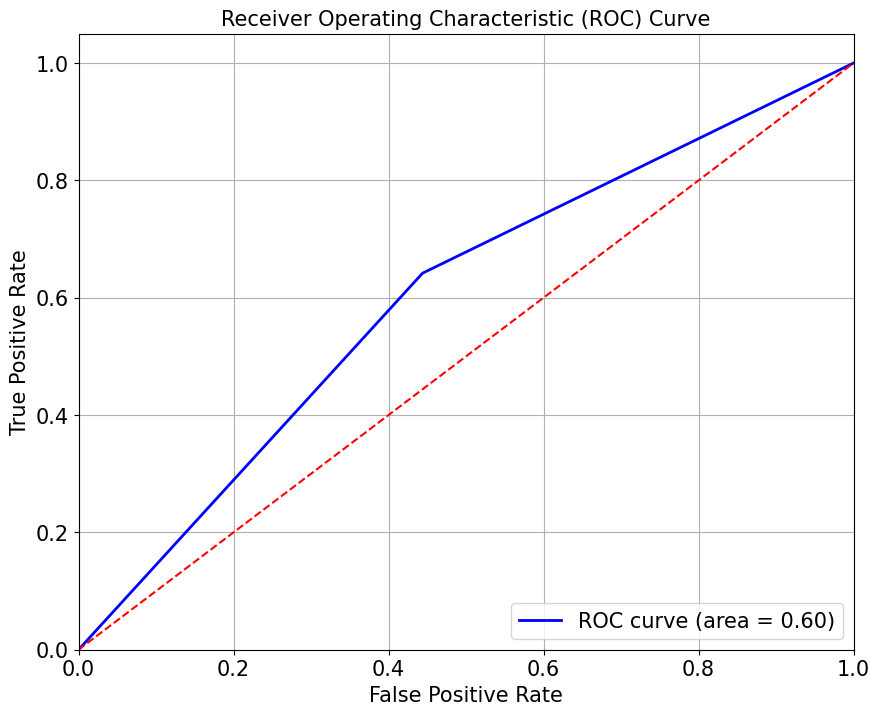

In [221]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

RF score: 0.603030303030303


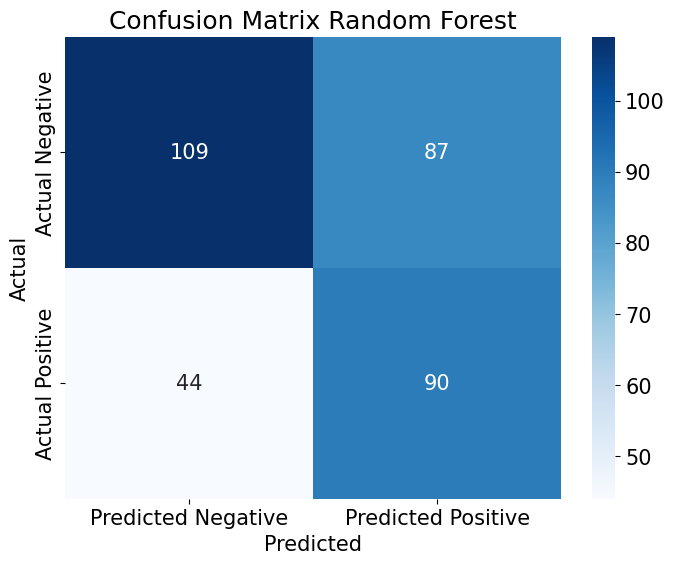

Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.56      0.62       196
         1.0       0.51      0.67      0.58       134

    accuracy                           0.60       330
   macro avg       0.61      0.61      0.60       330
weighted avg       0.63      0.60      0.61       330

F1 Score: 0.6060183924951428
ROC AUC Score: 0.613882120012184


In [222]:
# Downsampling + RandomForest

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_score = rf.score(X_test, y_test)
print("RF score:", rf_score)

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Random Forest')
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# roc score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

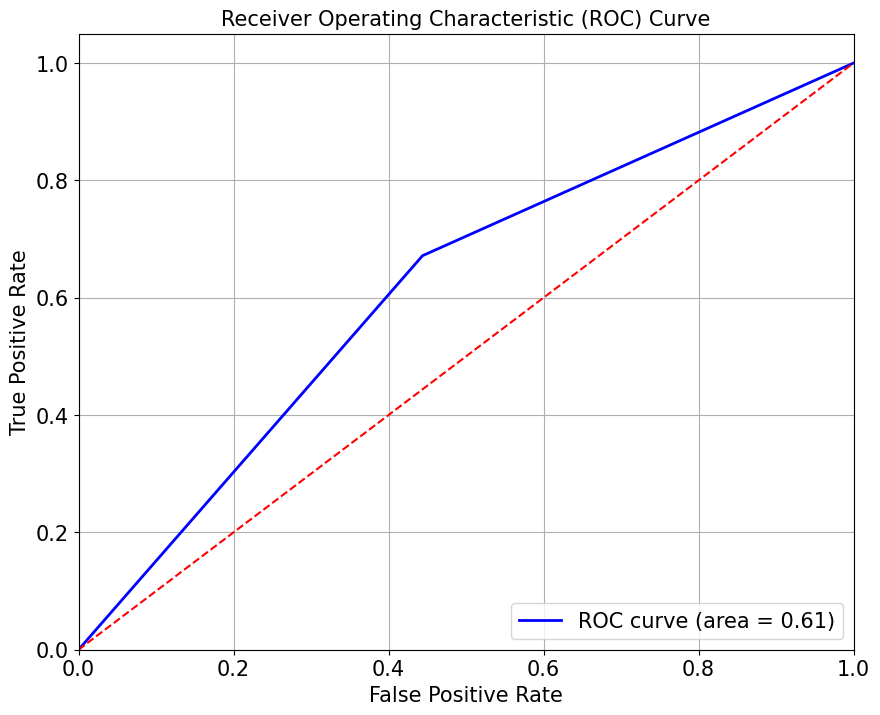

In [223]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

In [224]:
# Downsampling + LGBM

import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

lgb_model = lgb.LGBMClassifier(
                        objective='binary',
                        metrics='binary_logloss',
                        learning_rate=0.1,   # Giảm tốc độ học
                        max_depth=8,          # Độ sâu cây
                        num_leaves=8,        # Số lá
                        reg_alpha=0.05,        # Regularization term alpha
                        reg_lambda=0.05,       # Regularization term lambda
                        n_estimators=512,     # Số lượng cây
                        verbosity=-1
                        )

lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

print(classification_report(y_test, y_pred))

Accuracy: 0.5787878787878787
Weighted F1 Score: 0.5815203797812494
ROC AUC Score: 0.5911133109960403
              precision    recall  f1-score   support

         0.0       0.69      0.53      0.60       196
         1.0       0.49      0.66      0.56       134

    accuracy                           0.58       330
   macro avg       0.59      0.59      0.58       330
weighted avg       0.61      0.58      0.58       330



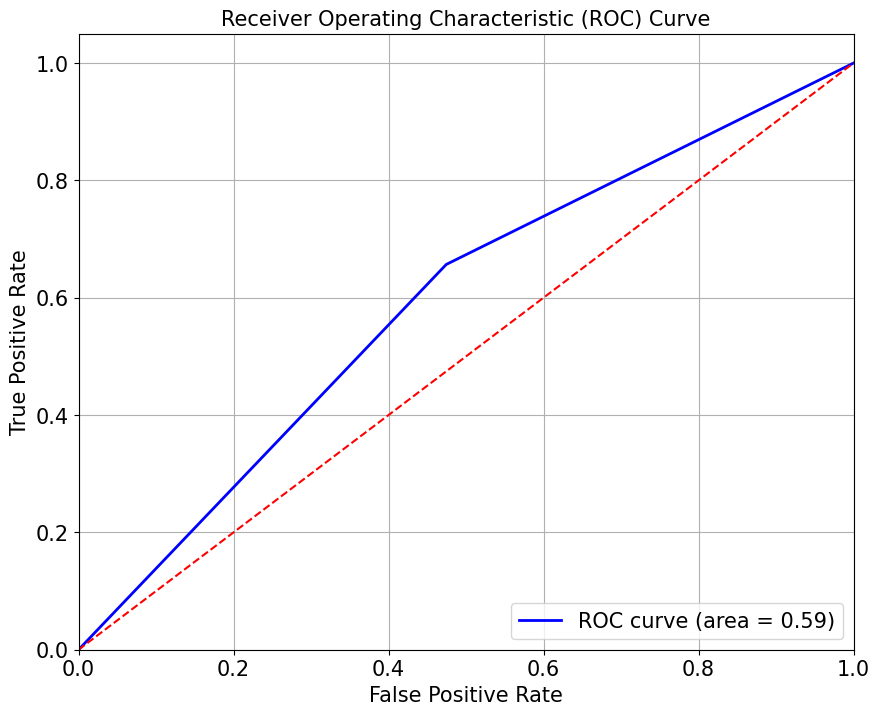

In [225]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

In [226]:
# Downsampling + LGBM

import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb


xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    max_depth=1,
    n_estimators=1024,
    reg_alpha=0.05,
    reg_lambda=0.05,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

print(classification_report(y_test, y_pred))

Accuracy: 0.6454545454545455
Weighted F1 Score: 0.648566181902611
ROC AUC Score: 0.6484160828510509
              precision    recall  f1-score   support

         0.0       0.73      0.63      0.68       196
         1.0       0.55      0.66      0.60       134

    accuracy                           0.65       330
   macro avg       0.64      0.65      0.64       330
weighted avg       0.66      0.65      0.65       330



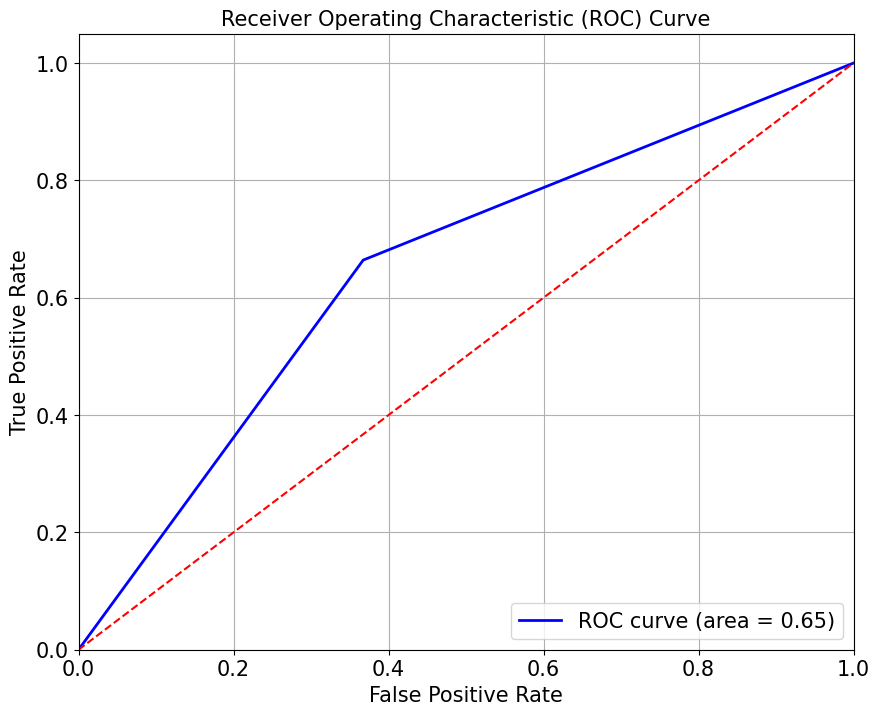

In [227]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

In [228]:
# Downsampling + ANN

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Ensure that X_train and X_test are DataFrames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Ensure that the data is numeric and has no missing values
X_train = X_train.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)  # .values to ensure numpy array
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)  # .values to ensure numpy array

# Define the ANN model
class ANN(nn.Module):
    def __init__(self, n_features, n_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Create the model, loss function, and optimizer
model = ANN(n_features=X_train.shape[1], n_classes=len(torch.unique(y_train)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted == y_test).sum().item()
    print(f'Test Accuracy: {(correct / total) * 100:.2f}%')

# Get predictions on the test set
# y_pred = outputs.detach().numpy()

# Optionally, if you want to get the predicted class labels instead of probabilities:
y_pred = predicted.detach().numpy()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

print(classification_report(y_test, y_pred))

Epoch [10/100], Loss: 0.6885
Epoch [20/100], Loss: 0.6788
Epoch [30/100], Loss: 0.6686
Epoch [40/100], Loss: 0.6597
Epoch [50/100], Loss: 0.6511
Epoch [60/100], Loss: 0.6417
Epoch [70/100], Loss: 0.6307
Epoch [80/100], Loss: 0.6182
Epoch [90/100], Loss: 0.6042
Epoch [100/100], Loss: 0.5896
Test Accuracy: 56.97%
Accuracy: 0.5696969696969697
Weighted F1 Score: 0.5735262821398756
ROC AUC Score: 0.5716570210173623
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       196
           1       0.48      0.58      0.52       134

    accuracy                           0.57       330
   macro avg       0.57      0.57      0.57       330
weighted avg       0.59      0.57      0.57       330



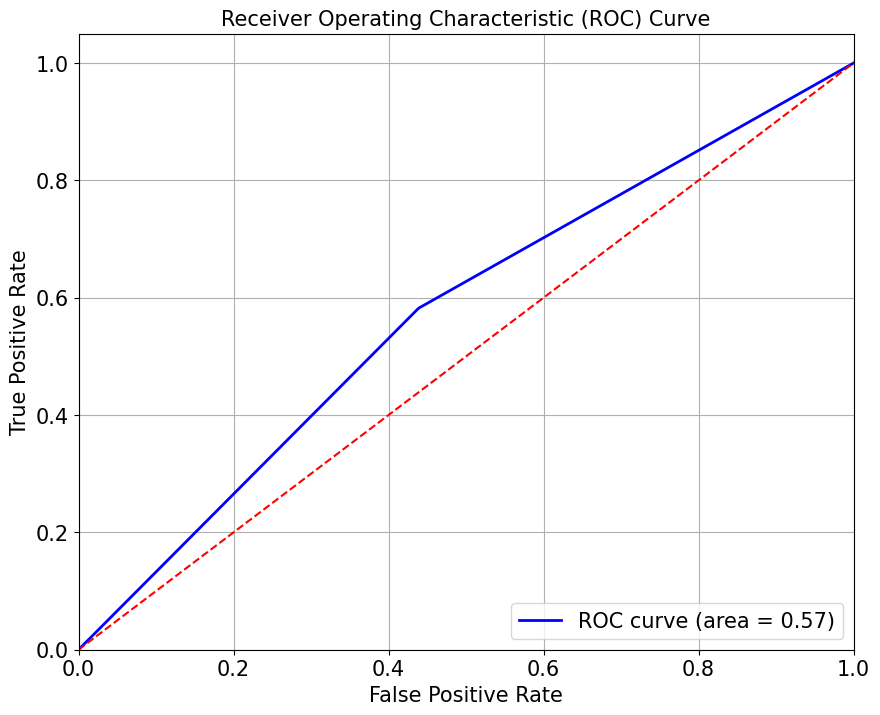

In [229]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

### Add RFE

In [230]:
# Downsampling + RFE + LogisticRegression

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

model = LogisticRegression()

for i in range(7, 18):
    print(i)
    rfe = RFE(estimator=model, n_features_to_select=i)

    rfe.fit(X_train, y_train)

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Weighted F1 Score: {f1}")
    print(f"ROC AUC Score: {roc_auc}")

    print(classification_report(y_test, y_pred))

7
Accuracy: 0.5575757575757576
Weighted F1 Score: 0.5596902852049911
ROC AUC Score: 0.5720758452634785
              precision    recall  f1-score   support

           0       0.67      0.49      0.57       196
           1       0.47      0.65      0.54       134

    accuracy                           0.56       330
   macro avg       0.57      0.57      0.56       330
weighted avg       0.59      0.56      0.56       330

8
Accuracy: 0.5575757575757576
Weighted F1 Score: 0.5596902852049911
ROC AUC Score: 0.5720758452634785
              precision    recall  f1-score   support

           0       0.67      0.49      0.57       196
           1       0.47      0.65      0.54       134

    accuracy                           0.56       330
   macro avg       0.57      0.57      0.56       330
weighted avg       0.59      0.56      0.56       330

9
Accuracy: 0.5424242424242425
Weighted F1 Score: 0.5436220297115819
ROC AUC Score: 0.5593207432226622
              precision    recall  f1

In [231]:
# Downsampling + RFE + SVM

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

model = LinearSVC(max_iter=10000)

for i in range(7, 18):
    print(i)
    rfe = RFE(estimator=model, n_features_to_select=i)

    rfe.fit(X_train, y_train)

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Weighted F1 Score: {f1}")
    print(f"ROC AUC Score: {roc_auc}")

    print(classification_report(y_test, y_pred))

7
Accuracy: 0.5545454545454546
Weighted F1 Score: 0.556842772961693
ROC AUC Score: 0.5683445019798965
              precision    recall  f1-score   support

           0       0.67      0.49      0.57       196
           1       0.46      0.64      0.54       134

    accuracy                           0.55       330
   macro avg       0.57      0.57      0.55       330
weighted avg       0.59      0.55      0.56       330

8
Accuracy: 0.5545454545454546
Weighted F1 Score: 0.556842772961693
ROC AUC Score: 0.5683445019798965
              precision    recall  f1-score   support

           0       0.67      0.49      0.57       196
           1       0.46      0.64      0.54       134

    accuracy                           0.55       330
   macro avg       0.57      0.57      0.55       330
weighted avg       0.59      0.55      0.56       330

9
Accuracy: 0.5424242424242425
Weighted F1 Score: 0.5436220297115819
ROC AUC Score: 0.5593207432226622
              precision    recall  f1-s

In [232]:
# Downsampling + RFE + RandomForest

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

rf = RandomForestClassifier()

for i in range(7, 18):
    print(i)
    rfe = RFE(estimator=rf, n_features_to_select=i)
    rfe.fit(X_train, y_train)

    selected_features = X_train.columns[rfe.support_]

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    rf_selected = RandomForestClassifier()
    rf_selected.fit(X_train_selected, y_train)

    y_pred = rf_selected.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Weighted F1 Score: {f1}")
    print(f"ROC AUC Score: {roc_auc}")

    print(classification_report(y_test, y_pred))

7
Accuracy: 0.5909090909090909
Weighted F1 Score: 0.5938373205741627
ROC AUC Score: 0.5859731952482485
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       196
           1       0.50      0.56      0.53       134

    accuracy                           0.59       330
   macro avg       0.58      0.59      0.58       330
weighted avg       0.60      0.59      0.59       330

8
Accuracy: 0.5696969696969697
Weighted F1 Score: 0.5734399870231252
ROC AUC Score: 0.5692963752665244
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       196
           1       0.47      0.57      0.52       134

    accuracy                           0.57       330
   macro avg       0.57      0.57      0.56       330
weighted avg       0.58      0.57      0.57       330

9
Accuracy: 0.5757575757575758
Weighted F1 Score: 0.5786816320229565
ROC AUC Score: 0.5696771245811758
              precision    recall  f1

In [233]:
# Downsampling + RFE + LGBM

import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

lgb_model = lgb.LGBMClassifier(
                        objective='binary',
                        metrics='binary_logloss',
                        learning_rate=0.1,
                        max_depth=8,
                        num_leaves=8,
                        reg_alpha=0.05,
                        reg_lambda=0.05,
                        n_estimators=512,
                        verbosity=-1
                        )

lgb_model.fit(X_train, y_train)

importances = lgb_model.feature_importances_

for i in range(7, 17):
    print(i)
    rfe = RFE(estimator=lgb_model, n_features_to_select = i)

    rfe.fit(X_train, y_train)

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    lgb_model_selected = lgb.LGBMClassifier()
    lgb_model_selected.fit(X_train_selected, y_train)

    y_pred = lgb_model_selected.predict(X_test_selected)

    # Đánh giá mô hình
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Weighted F1 Score: {f1}")
    print(f"ROC AUC Score: {roc_auc}")

7
[LightGBM] [Info] Number of positive: 1685, number of negative: 1685
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 3370, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.5545454545454546
Weighted F1 Score: 0.5582665985985071
ROC AUC Score: 0.5518199817240329
8
[LightGBM] [Info] Number of positive: 1685, number of negative: 1685
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 3370, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.590909090909090

In [234]:
# Downsampling + RFE + XGBoost

import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    max_depth=1,
    n_estimators=1024,
    reg_alpha=0.05,
    reg_lambda=0.05,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

for i in range(5, 10):
    print(i)
    rfe = RFE(estimator=xgb_model, n_features_to_select=i)
    rfe.fit(X_train, y_train)

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    xgb_model_selected = xgb.XGBClassifier(
        objective='binary:logistic',
        learning_rate=0.05,
        max_depth=1,
        n_estimators=1024,
        reg_alpha=0.05,
        reg_lambda=0.05,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    xgb_model_selected.fit(X_train_selected, y_train)

    y_pred = xgb_model_selected.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    print(f"Accuracy: {accuracy}")
    print(f"Weighted F1 Score: {f1}")
    print(f"ROC AUC Score: {roc_auc}")


5
Accuracy: 0.5212121212121212
Weighted F1 Score: 0.5249188660801565
ROC AUC Score: 0.5284800487359123
6
Accuracy: 0.5303030303030303
Weighted F1 Score: 0.5294619056086947
ROC AUC Score: 0.5514773073408469
7
Accuracy: 0.6515151515151515
Weighted F1 Score: 0.6535995358613411
ROC AUC Score: 0.6464361864148644
8
Accuracy: 0.6333333333333333
Weighted F1 Score: 0.6365881032547699
ROC AUC Score: 0.637031678342979
9
Accuracy: 0.6333333333333333
Weighted F1 Score: 0.6365881032547699
ROC AUC Score: 0.637031678342979


In [235]:
# Downsampling + RFE + XGBoost + n_features_to_select=7

import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    max_depth=1,
    n_estimators=1024,
    reg_alpha=0.05,
    reg_lambda=0.05,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

rfe = RFE(estimator=xgb_model, n_features_to_select=7)
rfe.fit(X_train, y_train)

X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

xgb_model_selected = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    max_depth=1,
    n_estimators=1024,
    reg_alpha=0.05,
    reg_lambda=0.05,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model_selected.fit(X_train_selected, y_train)

y_pred = xgb_model_selected.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.6515151515151515
Weighted F1 Score: 0.6535995358613411
ROC AUC Score: 0.6464361864148644


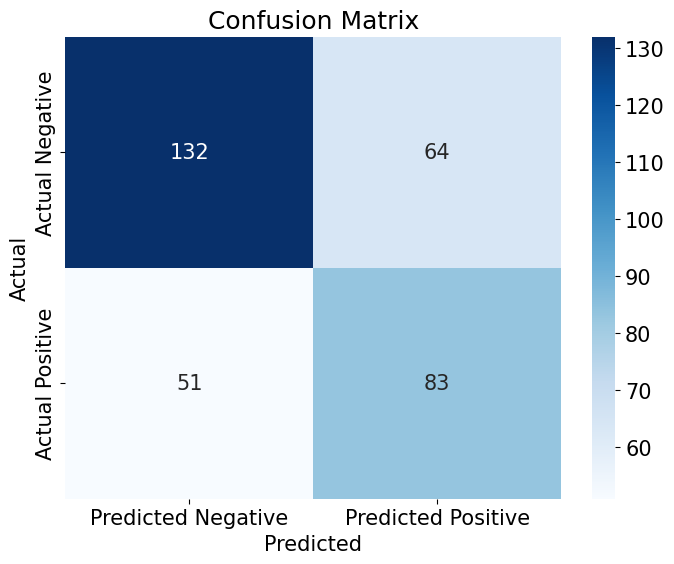

In [236]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

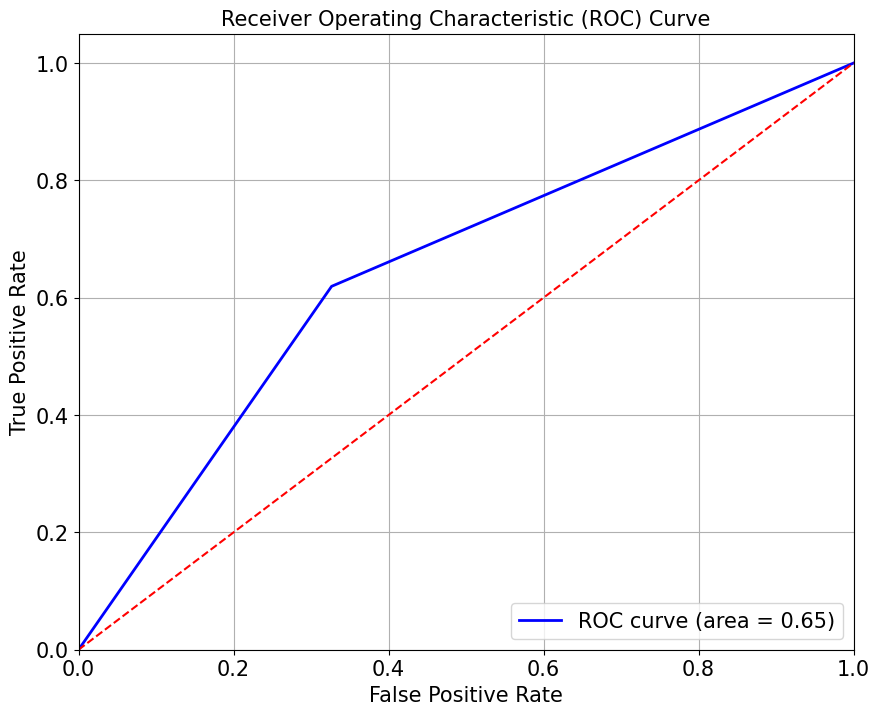

In [237]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

SOCIALMEDIA: downsample + rfe + XGBoost + n_features_to_select = 7 -> F1 Score: 0.6535995358613411

### DATASILVER

In [238]:
X_train = train_datasilver_3.drop(['accept', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M'], axis=1)
y_train = train_datasilver_3['accept']

X_test = test_datasilver_3.drop(['accept', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M'], axis=1)
y_test = test_datasilver_3['accept']

In [239]:
from sklearn.utils import resample
import pandas as pd

train_df = pd.concat([X_train, y_train], axis=1)

class_0 = train_df[train_df['accept'] == 0.0]
class_1 = train_df[train_df['accept'] == 1.0]

class_0_downsampled = resample(class_0,
                               replace=False,
                               n_samples=len(class_1),
                               random_state=42)

downsampled_df = pd.concat([class_0_downsampled, class_1])

X_train = downsampled_df.drop('accept', axis=1)
y_train = downsampled_df['accept']

print(y_train.value_counts())

accept
0.0    1641
1.0    1641
Name: count, dtype: int64


In [240]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [241]:
# Downsampling + RFE + LGBM

import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

lgb_model = lgb.LGBMClassifier(
                        objective='binary',
                        metrics='binary_logloss',
                        learning_rate=0.1,
                        max_depth=8,
                        num_leaves=8,
                        reg_alpha=0.05,
                        reg_lambda=0.05,
                        n_estimators=512,
                        verbosity=-1
                        )

lgb_model.fit(X_train, y_train)

importances = lgb_model.feature_importances_

for i in range(10, 17):
    print(i)
    rfe = RFE(estimator=lgb_model, n_features_to_select = i)

    rfe.fit(X_train, y_train)

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    lgb_model_selected = lgb.LGBMClassifier()
    lgb_model_selected.fit(X_train_selected, y_train)

    y_pred = lgb_model_selected.predict(X_test_selected)

    # Đánh giá mô hình
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Weighted F1 Score: {f1}")
    print(f"ROC AUC Score: {roc_auc}")

10
[LightGBM] [Info] Number of positive: 1641, number of negative: 1641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 3282, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.51171875
Weighted F1 Score: 0.5113833459266383
ROC AUC Score: 0.5121489621489622
11
[LightGBM] [Info] Number of positive: 1641, number of negative: 1641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 3282, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.53125
Weighted F1 S

In [242]:
# Downsampling + RFE + LGBM + n_features_to_select=14


import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

lgb_model = lgb.LGBMClassifier(
                        objective='binary',
                        metrics='binary_logloss',
                        learning_rate=0.1,
                        max_depth=8,
                        num_leaves=8,
                        reg_alpha=0.05,
                        reg_lambda=0.05,
                        n_estimators=512,
                        verbosity=-1
                        )

lgb_model.fit(X_train, y_train)

importances = lgb_model.feature_importances_

rfe = RFE(estimator=lgb_model, n_features_to_select = 14)

rfe.fit(X_train, y_train)

X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

lgb_model_selected = lgb.LGBMClassifier()
lgb_model_selected.fit(X_train_selected, y_train)

y_pred = lgb_model_selected.predict(X_test_selected)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

[LightGBM] [Info] Number of positive: 1641, number of negative: 1641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 3282, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.5703125
Weighted F1 Score: 0.5696816888916076
ROC AUC Score: 0.5697191697191697


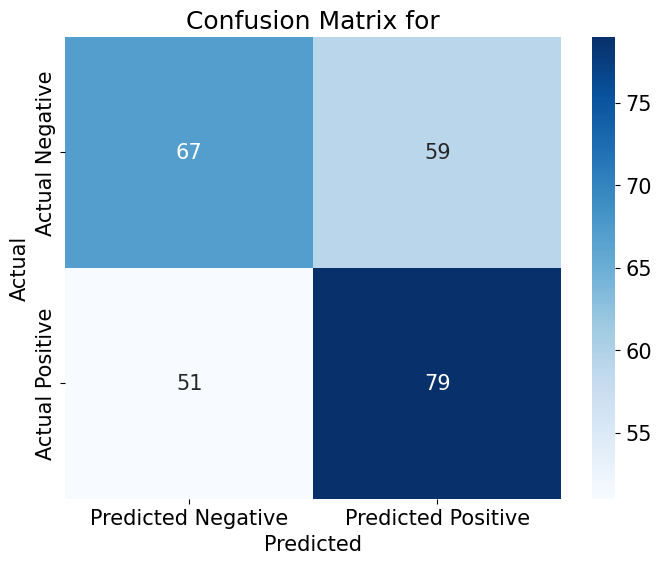

In [243]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for')
plt.show()

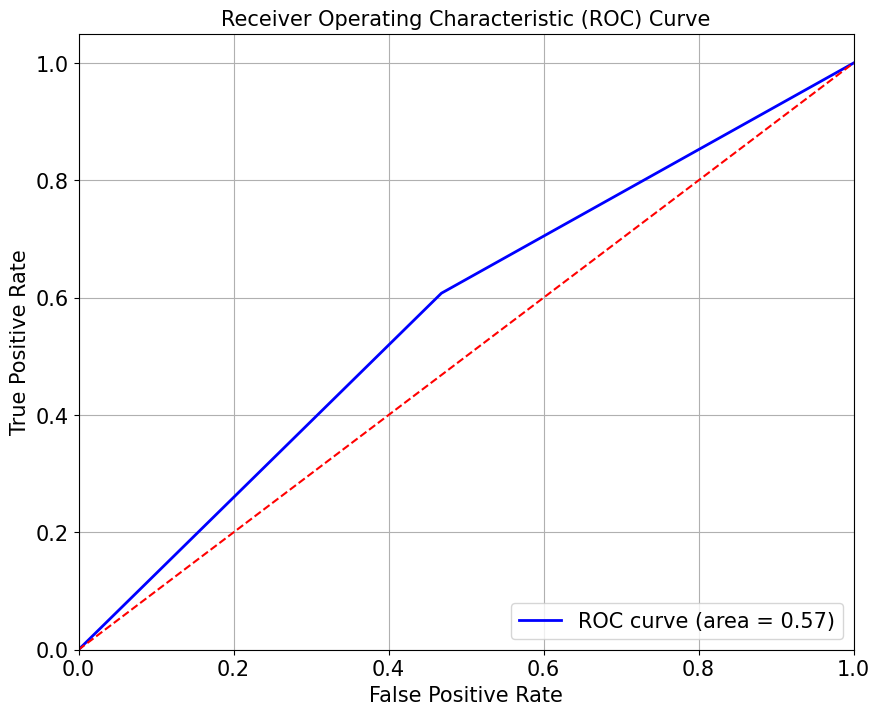

In [244]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

### DATAGOLD


In [245]:
X_train = train_datagold_3.drop('accept', axis=1)
y_train = train_datagold_3['accept']

X_test = test_datagold_3.drop('accept', axis=1)
y_test = test_datagold_3['accept']

In [246]:
from sklearn.utils import resample
import pandas as pd

# Giả định rằng X_train và y_train là các DataFrame
# Kết hợp X_train và y_train thành một DataFrame duy nhất
train_df = pd.concat([X_train, y_train], axis=1)

# Phân chia thành các lớp 0 và 1
class_0 = train_df[train_df['accept'] == 0.0]
class_1 = train_df[train_df['accept'] == 1.0]

# Downsample lớp 0
class_0_downsampled = resample(class_0,
                               replace=False,    # Không thay thế
                               n_samples=len(class_1), # Để lớp 0 bằng với lớp 1
                               random_state=10)  # Seed để tái lập

# Kết hợp lại các lớp để tạo thành một tập dữ liệu cân bằng
downsampled_df = pd.concat([class_0_downsampled, class_1])

# Tách lại X và y
X_train = downsampled_df.drop('accept', axis=1)
y_train = downsampled_df['accept']

# Kiểm tra lại sự cân bằng của các lớp
print(y_train.value_counts())

accept
0.0    735
1.0    735
Name: count, dtype: int64


In [247]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [248]:
# Downsampling + RFE + RF + n_features_to_select=9


from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

rf = RandomForestClassifier()

rfe = RFE(estimator=rf, n_features_to_select=9)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]

X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

rf_selected = RandomForestClassifier()
rf_selected.fit(X_train_selected, y_train)

y_pred = rf_selected.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

print(classification_report(y_test, y_pred))

Accuracy: 0.5583333333333333
Weighted F1 Score: 0.5719600725952814
ROC AUC Score: 0.5531813865147198
              precision    recall  f1-score   support

         0.0       0.72      0.57      0.63        81
         1.0       0.38      0.54      0.44        39

    accuracy                           0.56       120
   macro avg       0.55      0.55      0.54       120
weighted avg       0.61      0.56      0.57       120



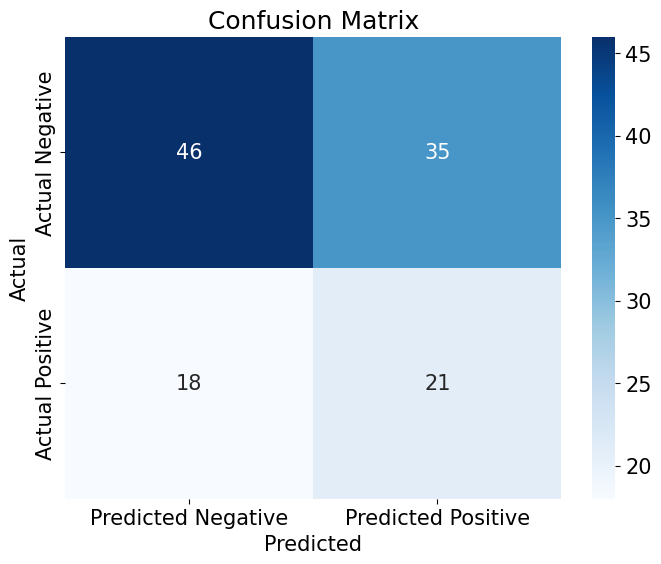

In [249]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

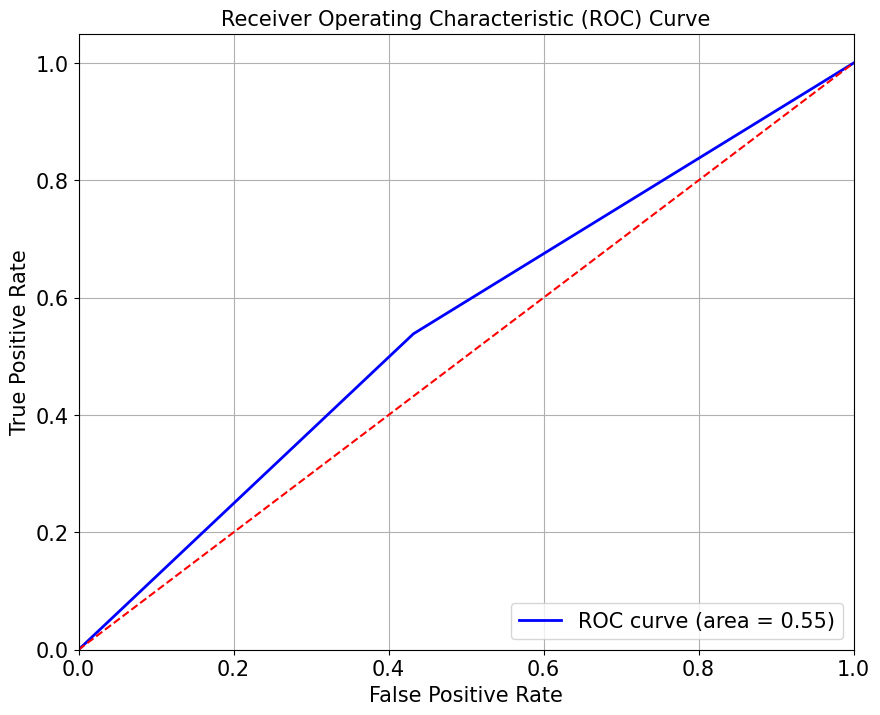

In [250]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

### SOCIALMEDIAGOLD

In [251]:
X_train = train_socialmediagold_3.drop('accept', axis=1)
y_train = train_socialmediagold_3['accept']

X_test = test_socialmediagold_3.drop('accept', axis=1)
y_test = test_socialmediagold_3['accept']

In [252]:
from sklearn.utils import resample
import pandas as pd

# Giả định rằng X_train và y_train là các DataFrame
# Kết hợp X_train và y_train thành một DataFrame duy nhất
train_df = pd.concat([X_train, y_train], axis=1)

# Phân chia thành các lớp 0 và 1
class_0 = train_df[train_df['accept'] == 0.0]
class_1 = train_df[train_df['accept'] == 1.0]

# Downsample lớp 0
class_0_downsampled = resample(class_0,
                               replace=False,    # Không thay thế
                               n_samples=len(class_1), # Để lớp 0 bằng với lớp 1
                               random_state=42)  # Seed để tái lập

# Kết hợp lại các lớp để tạo thành một tập dữ liệu cân bằng
downsampled_df = pd.concat([class_0_downsampled, class_1])

# Tách lại X và y
X_train = downsampled_df.drop('accept', axis=1)
y_train = downsampled_df['accept']

# Kiểm tra lại sự cân bằng của các lớp
print(y_train.value_counts())

accept
0.0    1487
1.0    1487
Name: count, dtype: int64


In [253]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [254]:
# Downsampling + RFE + RF + n_features_to_select=13

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

rf = RandomForestClassifier()

rfe = RFE(estimator=rf, n_features_to_select=13)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]

X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

rf_selected = RandomForestClassifier()
rf_selected.fit(X_train_selected, y_train)

y_pred = rf_selected.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

print(classification_report(y_test, y_pred))

Accuracy: 0.5550660792951542
Weighted F1 Score: 0.5555502199647252
ROC AUC Score: 0.5551613909246843
              precision    recall  f1-score   support

         0.0       0.52      0.56      0.54       106
         1.0       0.59      0.55      0.57       121

    accuracy                           0.56       227
   macro avg       0.55      0.56      0.55       227
weighted avg       0.56      0.56      0.56       227



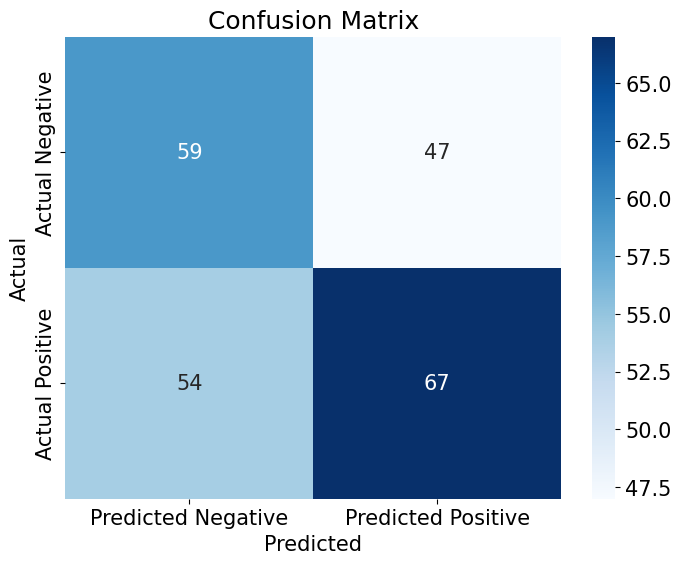

In [255]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

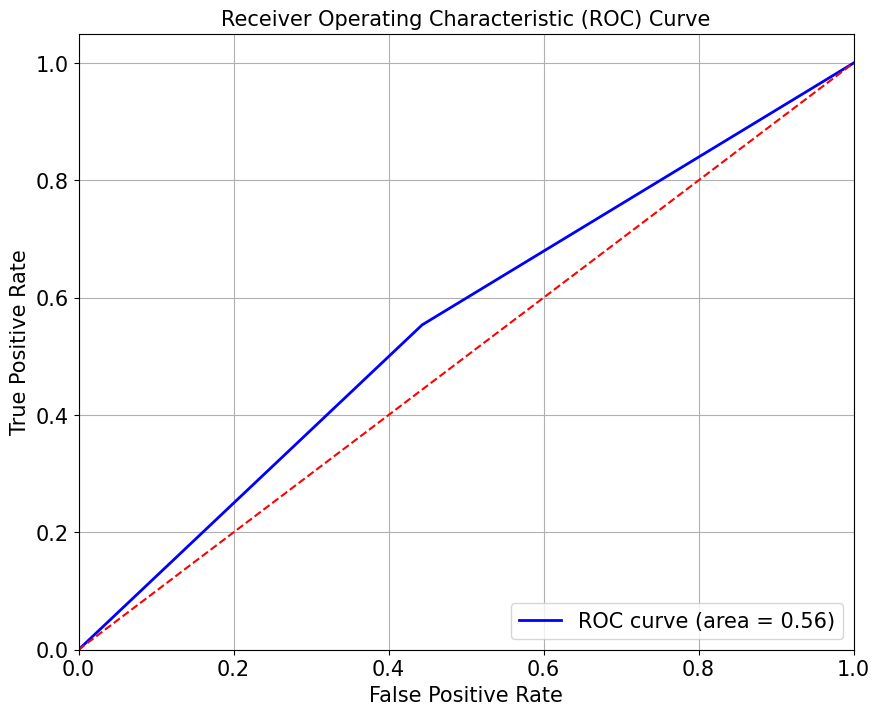

In [256]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()

### DATACALL

In [257]:
X_train = train_datacall_3.drop('accept', axis=1)
y_train = train_datacall_3['accept']

X_test = test_datacall_3.drop('accept', axis=1)
y_test = test_datacall_3['accept']

In [258]:
from sklearn.utils import resample
import pandas as pd

# Giả định rằng X_train và y_train là các DataFrame
# Kết hợp X_train và y_train thành một DataFrame duy nhất
train_df = pd.concat([X_train, y_train], axis=1)

# Phân chia thành các lớp 0 và 1
class_0 = train_df[train_df['accept'] == 0.0]
class_1 = train_df[train_df['accept'] == 1.0]

# Downsample lớp 0
class_0_downsampled = resample(class_0,
                               replace=False,    # Không thay thế
                               n_samples=len(class_1), # Để lớp 0 bằng với lớp 1
                               random_state=42)  # Seed để tái lập

# Kết hợp lại các lớp để tạo thành một tập dữ liệu cân bằng
downsampled_df = pd.concat([class_0_downsampled, class_1])

# Tách lại X và y
X_train = downsampled_df.drop('accept', axis=1)
y_train = downsampled_df['accept']

# Kiểm tra lại sự cân bằng của các lớp
print(y_train.value_counts())

accept
0.0    853
1.0    853
Name: count, dtype: int64


In [259]:
# Downsampling + RFE + RF


from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

rf = RandomForestClassifier()

for i in range(15, 20):
    print(i)
    rfe = RFE(estimator=rf, n_features_to_select=i)
    rfe.fit(X_train, y_train)

    selected_features = X_train.columns[rfe.support_]

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    rf_selected = RandomForestClassifier()
    rf_selected.fit(X_train_selected, y_train)

    y_pred = rf_selected.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Weighted F1 Score: {f1}")
    print(f"ROC AUC Score: {roc_auc}")

    print(classification_report(y_test, y_pred))

15
Accuracy: 0.659217877094972
Weighted F1 Score: 0.6695293153545759
ROC AUC Score: 0.5689979480164159
              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77       136
         1.0       0.33      0.40      0.36        43

    accuracy                           0.66       179
   macro avg       0.56      0.57      0.56       179
weighted avg       0.68      0.66      0.67       179

16
Accuracy: 0.7262569832402235
Weighted F1 Score: 0.738595825541296
ROC AUC Score: 0.6846785225718193
              precision    recall  f1-score   support

         0.0       0.86      0.76      0.81       136
         1.0       0.45      0.60      0.51        43

    accuracy                           0.73       179
   macro avg       0.65      0.68      0.66       179
weighted avg       0.76      0.73      0.74       179

17
Accuracy: 0.6815642458100558
Weighted F1 Score: 0.694480012915767
ROC AUC Score: 0.6155095759233926
              precision    recall  f1

In [260]:
# Downsampling + RFE + XGBoost + n_features_to_select=15


from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

rf = RandomForestClassifier()

rfe = RFE(estimator=rf, n_features_to_select=15)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]

X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

rf_selected = RandomForestClassifier()
rf_selected.fit(X_train_selected, y_train)

y_pred = rf_selected.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

print(classification_report(y_test, y_pred))

Accuracy: 0.6983240223463687
Weighted F1 Score: 0.704758921837019
ROC AUC Score: 0.6106361149110806
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       136
         1.0       0.39      0.44      0.41        43

    accuracy                           0.70       179
   macro avg       0.60      0.61      0.61       179
weighted avg       0.71      0.70      0.70       179



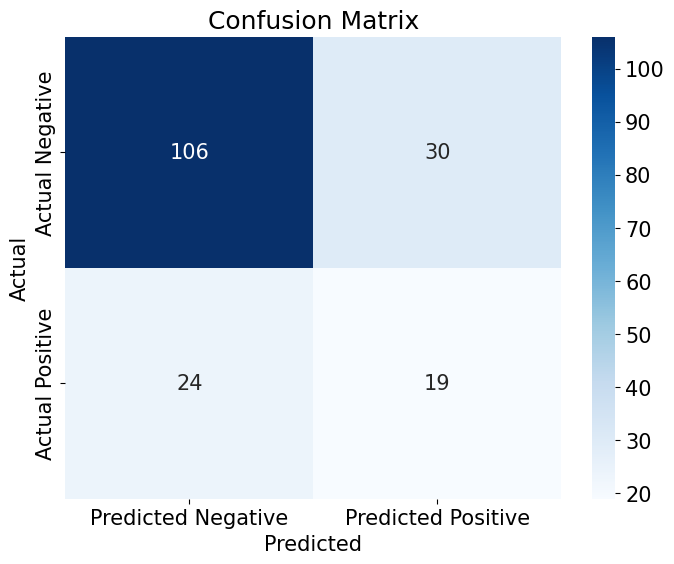

In [261]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

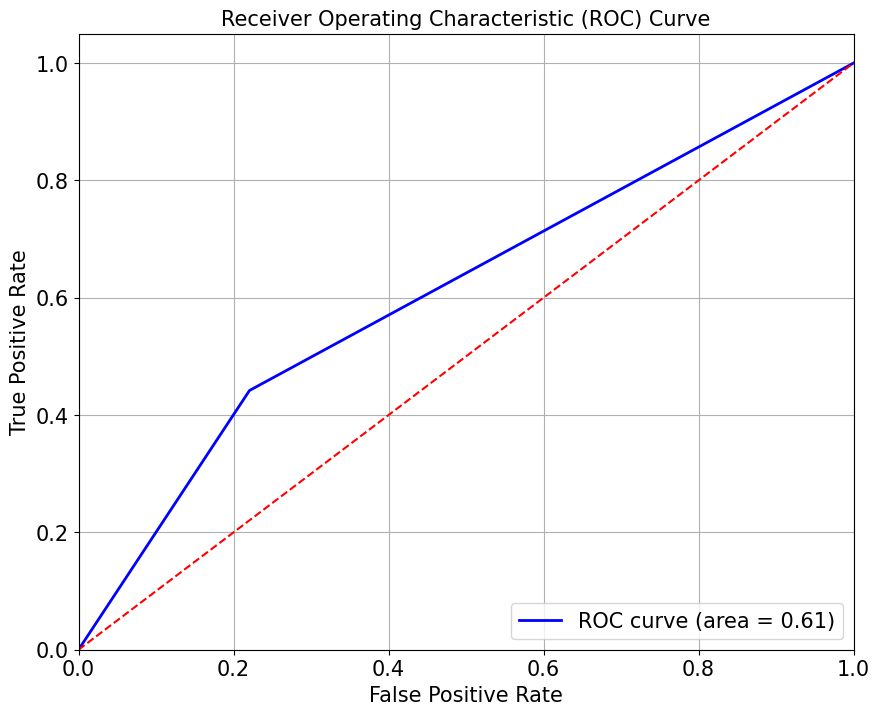

In [262]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.grid()
plt.show()